# Analysis Plan
********

# Data Exploration and feature identification

> Events in a patient's therapy can be broadly categorized into -
###  Diagnosis/Surgery events
        * How frequently is a patient diagnosed? What is the average gap between Dx for a patient?
        * How much does a patient spend on Dx?
        * What kind of surgeries involve opioid therapy?
        * ...
###  Claims/prescription events
        * How frequently a patient on opioid therapy takes opioid claims?
        * How much does a patient spends on opioid claims? Actual and OOP cost both...
        * Who are the payors in market? How's HUMANA doing in the market? Any close competitors?
        * What is the rejection ratio in the market? Across Payors?
        * What physician segments are prescribing opioids? Any specialization required to prescribe opioids?
        * ...
###  Promotional events
        * What do these calls mean, Mbr? Prov? Other?
        * How frequently a patient is being reached through these calls?
        * Are LTOT patients reached more frequently through these calls?
        * ...
        
# Feature selection
> Idea is to create a patient level feature matrix which will be used to predict LTOT patients. Features identified in previous stage can be used to build the feature matrix...

# Model fitting
> Classification problem
>> Logistic regression, KNN, Trees, Ensemble methods...

# Model validation and final results
> Based on model accuracy...

********
********


# Data related questions
******
> * What is the definition of 'on hand'? Any identifier in data to identify opioid medication from other medication?
#####  If a patient is taking opioids, he is 'on-hand'. "Rx Claim - Paid" with a valid MME defines an opioid Rx claim. 
> * What is the market basket for the given data? What all drugs other then opioids are included in the given data? 
Is entire diagnosis history of a patient who has taken opioid in the analysis timeframe available in the data?
##### Kind of Yes, the data captures events that are not related to opioids too.
> * What is difference between Rx cost, Net Paid amount (attr 4), Member responsible amount (attr 9) and Payble quantity? --to calculate cost related KPIs
##### Rx cost = Total cost ; Net paid amount = Amount paid by HUMANA (payor) = (Total cost - OOP)
> * What is 'New diagnosis top 5'?
##### Something regarding the other Dx patient went through apart from the ones listed. Not so important
> * In case of multiple initiation events for a patient, which event is reference point for #days given in 'days' column?
##### Initiation event  = Opioid Naive claim with a valid MME
##### Opiod Naive claim = No Opioid taken in 90 days lookback
> * what is the difference between event 'Fully Paid Claim' and 'RX Claim-Paid'?
##### Fully paid claim are medical claims where as Rx claim paid are pharmacy claims
> * Definition of LTOT - 
##### Patient >=162 days ‘on hand’ within 180 days after qualifying claim/Initiation event
##### A patient needs to be tagged as LTOT or not after every initiation event i.e. everytime a patient is decleared a new opioid patient, he/she needs to be tagged as LTOT or not.
##### Patient can have more than 1 initiation event which means patient has returned to the therapy and considered as new opioid patient. We have to predict about every new patients whether they will be on LTOT or not.
> * ...

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import zipfile
import nbformat
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def to_str(s):
    return str(s)

def to_float(s):
    return float(s)

def tx_cat(s):
    if s in('PAIN','OTH-STEROIDS','PSYCH-ANX','PSYCH-DEP','NUISANCE-SLEEP','PSYCH','NUISANCE-STIMULANTS',
            'CARDIO', 'CANCER', 'OTH-THYROID','OTH-GROWTH HORMONE'):
        return 'Pain Treatment'
    else:
        return 'Other Treatment'
    

In [4]:
# zf = zipfile.ZipFile('/Users/udbhavverma/Documents/Humana_case_2019/data/Download.zip')
# zf.printdir()

data_train = pd.read_csv('/Users/udbhavverma/Documents/Fall\'19/Data_HUMANA/Download/HMAHCC_COMP.csv')
data_ho = pd.read_csv('/Users/udbhavverma/Documents/Fall\'19/Data_HUMANA/Download/HMAHCC_HOLDOUT.csv')

data_ho.rename(columns={'ID':'id', 'EVENT_DESCR':'event_descr', 'EVENT_ATTR1':'event_attr1',
                           'EVENT_ATTR2':'event_attr2', 'EVENT_ATTR3':'event_attr3', 
                           'EVENT_ATTR4':'event_attr4', 'EVENT_ATTR5':'event_attr5', 
                           'EVENT_ATTR6':'event_attr6', 'EVENT_ATTR7':'event_attr7',
                           'EVENT_ATTR8':'event_attr8', 'EVENT_ATTR9':'event_attr9', 
                           'EVENT_ATTR10':'event_attr10', 'SPECIALTY':'Specialty', 
                           'SPECIALTY2':'Specialty2','SPECIALTY3':'Specialty3', 'days':'Days'},inplace=True)
print (data_ho.columns)
# data_train[:5]
print (len(data_ho))


/Users/udbhavverma/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['id', 'event_descr', 'event_attr1', 'event_attr2', 'event_attr3',
       'event_attr4', 'event_attr5', 'event_attr6', 'event_attr7',
       'event_attr8', 'event_attr9', 'event_attr10', 'PAY_DAY_SUPPLY_CNT',
       'PAYABLE_QTY', 'MME', 'DRUG_TYPE', 'Specialty', 'Specialty2',
       'Specialty3', 'Days'],
      dtype='object')
1480394


In [5]:
# ## Creating event categories

def event_cat(s):
        if s[0:7] == 'Inbound':
            return 'Call'
        elif s[0:13] =='New diagnosis':
            return 'Diagnosis'
        elif s[0:2] == 'RX':
            return 'RxClaim'
        elif s =='New provider':
            return 'Provider'
        else:
            return 'Claim'
        
data_train['event_category'] = data_train['event_descr'].map(event_cat)   
data_ho['event_category'] = data_ho['event_descr'].map(event_cat)

print (data_train['event_category'].value_counts())
data_train[['event_category','event_descr']].drop_duplicates()
len(data_ho)

RxClaim      3690174
Claim        1766863
Call          442599
Provider      171288
Diagnosis      16045
Name: event_category, dtype: int64


1480394

# Holdout set processing

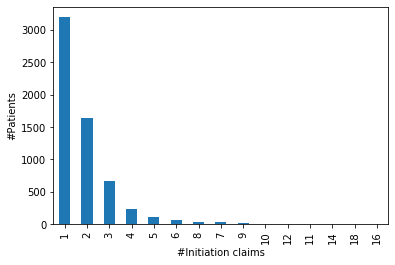

There are patients with more than 1 day=0 events
No of opioid claims taken on day0 and count of patient
1    5800
2     132
0      67
3       1
Name: sum, dtype: int64


/Users/udbhavverma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


(28167, 17)


,id,episode_num,episode_start_day,episode_end_day,actual_dos,PAY_DAY_SUPPLY_CNT,PAYABLE_QTY,total_rx_MME,rx_cost,mem_res_cost,prescribed_MME_per_day,consumed_MME_per_day,in_next_180_days,cutoff_180_day,days_on_op_next_180,LTOT_flag,category
0,ID10006701904,1.0,-331,-271.0,60.0,60.0,180.0,2700.0,12.99,2.65,45.000000,45.000000,0,0.0,60.0,0.0,pre
1,ID10006701904,2.0,-245,-138.0,107.0,120.0,360.0,5400.0,25.98,5.30,45.000000,50.467290,0,0.0,60.0,0.0,pre
2,ID10006701904,3.0,0,60.0,60.0,60.0,180.0,2700.0,12.99,2.95,45.000000,45.000000,1,60.0,60.0,0.0,post
3,ID10020514442,1.0,-549,-542.0,7.0,7.0,28.0,560.0,7.54,7.54,80.000000,80.000000,0,0.0,15.0,0.0,pre
4,ID10020514442,2.0,-540,-530.0,10.0,10.0,60.0,1800.0,14.90,14.90,180.000000,180.000000,0,0.0,15.0,0.0,pre
5,ID10020514442,3.0,0,15.0,15.0,15.0,15.0,75.0,2.95,2.95,5.000000,5.000000,1,15.0,15.0,0.0,post
6,ID10025902702,1.0,0,10.0,10.0,10.0,40.0,800.0,6.20,6.20,80.000000,80.000000,1,10.0,10.0,0.0,post
7,ID10028172382,1.0,-899,-857.0,42.0,44.0,114.0,2167.5,19.80,19.80,49.261364,51.607143,0,0.0,90.0,0.0,pre
8,ID10028172382,2.0,-815,-800.0,15.0,15.0,30.0,270.0,7.79,7.79,18.000000,18.000000,0,0.0,90.0,0.0,pre
9,ID10028172382,3.0,-795,-785.0,10.0,10.0,60.0,1800.0,5.00,5.00,180.000000,180.000000,0,0.0,90.0,0.0,pre


In [6]:
# ##Patients with >1 initiation (days=0)
rx = data_ho[(data_ho['event_category']=='RxClaim')]#[:1000]
rx.shape
rx_paid_claim = rx[(rx['event_descr']=='RX Claim - Paid') & (rx['Days']==0)]
rx_paid_claim_pat = rx_paid_claim.groupby(['id'])[['event_descr']].count().rename(columns={'event_descr':'count'})
rx_paid_claim_pat['count'].value_counts().plot(kind='bar')
xlabel('#Initiation claims')
ylabel('#Patients')
show()
print ('There are patients with more than 1 day=0 events') # ##ID10081072715 :3 claims on day 0

# ## Naive Opioid claims
rx['Naive_opioid_claim'] = np.where((rx['event_descr']=='RX Claim - Paid')& (rx['Days']==0) & (~rx['MME'].isnull()),1,0)
rx_naive_claims_pat = rx.groupby(['id'])[['Naive_opioid_claim']].sum().rename(columns={'Naive_opioid_claim':'sum'})
print ('No of opioid claims taken on day0 and count of patient')
print (rx_naive_claims_pat['sum'].value_counts())


# ##Opioid Episode level summary with LTOT flag
rx_op_claim = rx[(rx['event_descr']=='RX Claim - Paid')&(~rx['MME'].isnull())].sort_values(['id','Days'])
rx_op_claim['total_rx_MME'] = rx_op_claim['MME']*rx_op_claim['PAYABLE_QTY']
rx_op_claim['rx_cost'] = rx_op_claim['event_attr3'].map(to_float)
rx_op_claim['mem_res_cost'] = rx_op_claim['event_attr9'].map(to_float)
rx_op_claim = rx_op_claim.groupby(['id','Days'])[['rx_cost','mem_res_cost','PAY_DAY_SUPPLY_CNT','PAYABLE_QTY','total_rx_MME']].sum()
rx_op_claim.reset_index(inplace=True)
rx_op_claim['MME'] = 1*rx_op_claim['total_rx_MME']/rx_op_claim['PAY_DAY_SUPPLY_CNT']

grace = 0
# rx_op_claim = rx_op_claim[rx_op_claim['id']=='ID10010854159']
# ID10010854159
# ID10433575841
rx_op_claim['claim_end_day'] = rx_op_claim['Days']+rx_op_claim['PAY_DAY_SUPPLY_CNT']
rx_op_claim['next_op'] = rx_op_claim.groupby("id")['Days'].shift(-1) 
rx_op_claim['actual_dos'] = np.where((rx_op_claim['claim_end_day']<rx_op_claim['next_op'])|(rx_op_claim['next_op'].isnull()),rx_op_claim['PAY_DAY_SUPPLY_CNT'],rx_op_claim['next_op']-rx_op_claim['Days'])
rx_op_claim['gap_to_next_op'] = rx_op_claim['next_op']-rx_op_claim['claim_end_day']
rx_op_claim['previous_op_end_day'] = rx_op_claim.groupby("id")['claim_end_day'].shift(1) 
rx_op_claim['gap_from_previous_op'] = rx_op_claim['Days']-rx_op_claim['previous_op_end_day']
rx_op_claim['new_patient_flag'] = np.where((rx_op_claim['gap_from_previous_op'].isnull())|(rx_op_claim['gap_from_previous_op']>90),1,0)

# rx_op_claim.groupby('id')['new_patient_flag'].sum().value_counts().plot(kind='bar')

rx_op_claim['is_episode_start'] = np.where((rx_op_claim['gap_from_previous_op']>grace)|(rx_op_claim['gap_from_previous_op'].isnull()),1,0)
rx_op_claim['is_episode_end'] = np.where((rx_op_claim['next_op']>rx_op_claim['claim_end_day']+grace)|(rx_op_claim['gap_to_next_op'].isnull()),1,0)

rx_op_claim['episode_start_day'] = np.where((rx_op_claim['gap_from_previous_op']>grace)|(rx_op_claim['gap_from_previous_op'].isnull()),rx_op_claim['Days'],999999999)
rx_op_claim['episode_end_day'] = np.where((rx_op_claim['next_op']>rx_op_claim['claim_end_day']+grace)|(rx_op_claim['gap_to_next_op'].isnull()),rx_op_claim['claim_end_day'],-99999999)
rx_op_claim['episode_rank'] = rx_op_claim.groupby(['id','is_episode_start'])['episode_start_day'].rank(method='dense')

# rx_op_claim
rx_op_claim.reset_index(inplace=True)
for index, row in rx_op_claim.iterrows():      
    if int(index)==0:
        rx_op_claim.loc[index,'episode_num'] = 1
    else:
        if (rx_op_claim.loc[index,'is_episode_start']==0)&(rx_op_claim.loc[index,'episode_rank']==1):
            rx_op_claim.loc[index,'episode_num'] = rx_op_claim.loc[int(index)-1,'episode_num']
        else:
            rx_op_claim.loc[index,'episode_num'] = rx_op_claim.loc[index,'episode_rank']

aggregation = {'episode_start_day':min,'episode_end_day':max,'actual_dos':sum,
               'PAY_DAY_SUPPLY_CNT':sum,'PAYABLE_QTY':sum,'total_rx_MME':sum,
               'rx_cost':sum,'mem_res_cost':sum}        
rx_op_episode = rx_op_claim.groupby(['id','episode_num']).agg(aggregation)
rx_op_episode['prescribed_MME_per_day'] = 1*rx_op_episode['total_rx_MME']/rx_op_episode['PAY_DAY_SUPPLY_CNT']
rx_op_episode['consumed_MME_per_day'] = 1*rx_op_episode['total_rx_MME']/rx_op_episode['actual_dos']
rx_op_episode['in_next_180_days'] = np.where((rx_op_episode['episode_start_day']>=0)&(rx_op_episode['episode_start_day']<180),1,0)
rx_op_episode['cutoff_180_day'] = np.where((rx_op_episode['in_next_180_days']==1)&(rx_op_episode['episode_end_day']<180),rx_op_episode['episode_end_day'],180)

rx_op_episode.reset_index(inplace=True)
for index, row in rx_op_episode.iterrows():
    if rx_op_episode.loc[index,'in_next_180_days']==1:
        if (rx_op_episode.loc[index,'episode_end_day']<180):
            rx_op_episode.loc[index,'cutoff_180_day'] = rx_op_episode.loc[index,'episode_end_day']-rx_op_episode.loc[index,'episode_start_day']
        else:
            rx_op_episode.loc[index,'cutoff_180_day'] = 180-rx_op_episode.loc[index,'episode_start_day']
    else:
        rx_op_episode.loc[index,'cutoff_180_day'] = 0
        
rx_op_episode_180 = rx_op_episode[rx_op_episode['in_next_180_days']==1]
rx_op_episode_180_1 = rx_op_episode_180.groupby(['id'])['cutoff_180_day'].sum()
rx_op_episode_180_1 = pd.DataFrame({'id':rx_op_episode_180_1.index, 'days_on_op_next_180':rx_op_episode_180_1.values})
rx_op_episode_180_1['LTOT_flag'] = np.where(rx_op_episode_180_1['days_on_op_next_180']>=162,1,0)
rx_op_episode =  rx_op_episode.merge(rx_op_episode_180_1,
                                      left_on='id',
                                      right_on='id',
                                      how='left',
                                      suffixes=['_ep', '_LTOT'])
rx_op_episode['category'] = np.where(rx_op_episode['episode_start_day']<0,'pre','post')

print (rx_op_episode.shape)

rx_op_episode[:10]

# holdout feature extraction

In [7]:
# ## coding parameters
# import re
warnings.filterwarnings('ignore')
col = ['id','event_descr','event_attr1','event_attr2','event_attr3','event_attr4','event_attr5','Days_d']
drop_col = ['event_attr1','event_attr2','event_attr3','event_attr4','event_attr5','event_attr6','event_attr7','event_attr8']

# ################################
# Feature extraction:
# Pre/Post-
# Total number of opioid episodes
# total length of episode:sum(episode_len)
# total length of therapy:max(episode_end)-min(episode_start)

# Gap from last Opioid before initiation : 
    
# ################################

# data_ho=data_ho[:1000]
data_dx = data_ho[(data_ho['event_category']=='Claim')]
data_dx['pre_flag'] = np.where(data_dx['Days']<=0,1,0)

# --------------Opioid intake related features
aggregation = {'actual_dos':sum,'PAY_DAY_SUPPLY_CNT':sum,'PAYABLE_QTY':sum,'total_rx_MME':sum,
              'rx_cost':sum,'mem_res_cost':sum}        
id_op_mat = rx_op_episode.groupby(['id','category']).agg(aggregation)
id_op_mat.reset_index(inplace=True)
id_op_mat = id_op_mat[id_op_mat['category']=='pre']
id_op_mat.drop('category',axis=1,inplace=True)
id_op_mat.set_index('id',inplace=True)
id_op_mat.shape

# ------ Latest Dx before initiation (day=0) and days since last Dx
data_dx_pre = data_dx[(data_dx['pre_flag']==1)&(data_dx['event_descr']=='Fully Paid Claim')]
# data_dx_pre = data_dx_pre[data_dx_pre['id_d']== 'ID71291582272'] 
idx = data_dx_pre.groupby(['id'])['Days'].transform(max) == data_dx_pre['Days']
latest_dx = data_dx_pre[idx]        
latest_dx1 = latest_dx.groupby(['id','event_attr1','event_attr2','Days'])[['id']].count().rename(columns={'id':'count'})
latest_dx1.reset_index(inplace=True)
latest_dx1['rank_count'] = latest_dx1.groupby(['id'])['count'].rank(method='first',ascending=False)
latest_dx_id = latest_dx1[latest_dx1['rank_count']==1]
latest_dx_id = latest_dx_id[['id','event_attr1','event_attr2','Days']].rename(columns={'event_attr1':'latest_dx_desc','event_attr2':'latest_dx_pot','Days':'Days_last_dx'})
latest_dx_id.set_index('id',inplace=True)

# ------ other Dx features
data_dx_pre['tot_charge_amt'] = data_dx_pre['event_attr3'].map(to_float)
data_dx_pre['net_paid_amt'] = data_dx_pre['event_attr4'].map(to_float)
data_dx_pre['mbr_res_amt'] = data_dx_pre['event_attr5'].map(to_float)
data_dx_pre['mbr_res_amt'] = np.where(data_dx_pre['mbr_res_amt']<0,0,data_dx_pre['mbr_res_amt'])
feature_dx1 = data_dx_pre.groupby(['id'])[['tot_charge_amt','net_paid_amt','mbr_res_amt']].sum()
feature_dx1 = feature_dx1.reset_index()
feature_dx1.set_index('id',inplace=True)

# feature_dx1.plot.scatter(x='net_paid_amt',y='mbr_res_amt',c='LTOT_flag',colormap='viridis',sharex=False)
# feature_dx1.hist(bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=1.5)
# show()
# feature_dx1.describe()

# ------ latest New Dx before initiation (day=0) and days since last new Dx
data_new_dx = data_ho[(data_ho['event_category']=='Diagnosis')]
data_new_dx['pre_flag'] = np.where(data_new_dx['Days']<=0,1,0)
data_new_dx_pre = data_new_dx[(data_new_dx['pre_flag']==1)]
nidx = data_new_dx_pre.groupby(['id'])['Days'].transform(max) == data_new_dx_pre['Days']
latest_new_dx = data_new_dx_pre[nidx]  
latest_new_dx['new_dx_CPD'] = np.where(latest_new_dx['event_descr']=='New diagnosis - CPD',1,0)
latest_new_dx['new_dx_hypertension'] = np.where(latest_new_dx['event_descr']=='New diagnosis - Hypertension',1,0)
latest_new_dx['new_dx_top5'] = np.where(latest_new_dx['event_descr']=='New diagnosis - Top 5',1,0)
latest_new_dx['new_dx_CAD'] = np.where(latest_new_dx['event_descr']=='New diagnosis - CAD',1,0)
latest_new_dx['new_dx_diabetes'] = np.where(latest_new_dx['event_descr']=='New diagnosis - Diabetes',1,0)
latest_new_dx['new_dx_CHF'] = np.where(latest_new_dx['event_descr']=='New diagnosis - CHF',1,0)
latest_new_dx_id = latest_new_dx.groupby(['id','Days'])['new_dx_CPD','new_dx_hypertension','new_dx_top5','new_dx_CAD','new_dx_diabetes','new_dx_CHF'].max()
latest_new_dx_id = latest_new_dx_id.reset_index().rename(columns={'Days':'latest_new_dx_day'})
latest_new_dx_id.set_index('id',inplace=True)
latest_new_dx_id.describe()
# latest_new_dx_id[:5]
# 5711 patients with new dx

# ------- calls related features
data_call = data_ho[(data_ho['event_category']=='Call')]
data_call['pre_flag'] = np.where(data_call['Days']<=0,1,0)
data_call_pre = data_call[data_call['pre_flag']==1]
data_call_pre_id = data_call_pre.groupby(['id','event_descr'])[['id']].count().rename(columns={'id':'number_calls'})
data_call_pre_id.reset_index(inplace=True)
data_call_pre_id['call_by_mbr'] = np.where(data_call_pre_id['event_descr']=='Inbound Call by Mbr',data_call_pre_id['number_calls'],0)
data_call_pre_id['call_by_prov'] = np.where(data_call_pre_id['event_descr']=='Inbound Call by Prov',data_call_pre_id['number_calls'],0)
data_call_pre_id['call_by_other'] = np.where(data_call_pre_id['event_descr']=='Inbound Call by Other',data_call_pre_id['number_calls'],0)
feature_data_call = data_call_pre_id.groupby(['id'])['call_by_mbr','call_by_prov','call_by_other'].max()
feature_data_call = feature_data_call.reset_index()
feature_data_call.set_index('id',inplace=True)
# feature_data_call[:5]

# ------- provider related features
data_prov = data_ho[(data_ho['event_category']=='Provider')]
data_prov['pre_flag'] = np.where(data_prov['Days']<=0,1,0)
data_prov_pre = data_prov[data_prov['pre_flag']==1]
pidx = data_prov_pre.groupby(['id'])['Days'].transform(max) == data_prov_pre['Days']
latest_new_prov = data_prov_pre[pidx]  
latest_new_prov = latest_new_prov[['id','Days']].rename(columns={'Days':'latest_new_prov_date'})
# latest_new_prov = latest_new_prov.reset_index()
latest_new_prov.set_index('id',inplace=True)

# ------ Latest Surgery before initiation (day=0) and days since last surgery
data_sx_pre = data_dx[(data_dx['pre_flag']==1)&(data_dx['event_descr']=='Surgery')]
# data_sx_pre = data_sx_pre[data_sx_pre['id_d']== 'ID99421949451'] 
idsx = data_sx_pre.groupby(['id'])['Days'].transform(max) == data_sx_pre['Days']
latest_sx = data_sx_pre[idsx]

latest_sx1 = latest_sx.groupby(['id','event_attr1','event_attr2','Days'])[['id']].count().rename(columns={'id':'count'})
latest_sx1.reset_index(inplace=True)
latest_sx1['rank_count'] = latest_sx1.groupby(['id'])['count'].rank(method='first',ascending=False)
latest_sx_id = latest_sx1[latest_sx1['rank_count']==1]
latest_sx_id = latest_sx_id[['id','event_attr1','event_attr2','Days']].rename(columns={'event_attr1':'latest_sx_desc','event_attr2':'latest_sx_pot','Days':'Days_last_sx'})
latest_sx_id.set_index('id',inplace=True)



# ---------------------------Rx feature code
rx_other_paid = rx[rx['event_descr'] == 'RX Claim - Paid']

rx_other_paid['tx_cat'] = rx_other_paid['event_attr6'].map(tx_cat)
rx_other_paid['tx_cat'] = np.where(~rx_other_paid['MME'].isnull(),'Opioid Treatment',rx_other_paid['tx_cat'])

#taking only negative day claims for analysis further
rx_other_paid = rx_other_paid[rx_other_paid['Days'] <0]

# Total claim count
rx_other_paid0 = pd.DataFrame(rx_other_paid.groupby('id')['id'].agg('count'))
rx_other_paid0.columns = ['claim_count']
rx_other_paid0.reset_index(inplace=True)
rx_other_paid0.set_index('id',inplace=True)

# Total claim count by category
rx_other_paid1 = pd.DataFrame(rx_other_paid.groupby(['id', 'tx_cat'])['id'].agg('count'))
rx_other_paid1.columns = ['claim_count']
rx_other_paid1.reset_index(inplace=True)
rx_other_paid2 = pd.DataFrame(pd.pivot_table(rx_other_paid1, index = 'id', columns = 'tx_cat', values = 'claim_count')).reset_index()
rx_other_paid2.fillna(0, inplace=True)
rx_other_paid2.set_index('id',inplace=True)

# Average gap between two claims of same category
rx_other_paid['claim_end_day'] = rx_other_paid['Days']+rx_other_paid['PAY_DAY_SUPPLY_CNT']
rx_other_paid3 = rx_other_paid[['id', 'tx_cat', 'Days', 'claim_end_day']]
rx_other_paid3['same_cat_next_claim_day'] = rx_other_paid3.groupby(["id","tx_cat"])['Days'].shift(-1)
rx_other_paid3['next_claim_day'] = rx_other_paid3.groupby("id")['Days'].shift(-1)
rx_other_paid3['same_cat_gap'] = rx_other_paid3['same_cat_next_claim_day']-rx_other_paid3['Days']
rx_other_paid3['gap'] = rx_other_paid3['next_claim_day']-rx_other_paid3['Days']
rx_other_paid4 = pd.DataFrame(rx_other_paid3.groupby(['id','tx_cat'])['same_cat_gap'].mean())
rx_other_paid4.columns = ['same_cat_avg_gap']
rx_other_paid4.reset_index(inplace=True)
rx_other_paid4 = pd.DataFrame(pd.pivot_table(rx_other_paid4, index = 'id', columns = 'tx_cat', values = 'same_cat_avg_gap')).reset_index()
rx_other_paid4.fillna(0, inplace=True)
rx_other_paid4.set_index('id',inplace=True)

# Average gap between two claims overall
rx_other_paid5 = pd.DataFrame(rx_other_paid3.groupby('id')['gap'].mean())
rx_other_paid5.columns = ['avg_gap']
rx_other_paid5.reset_index(inplace=True)
rx_other_paid5.set_index('id',inplace=True)

# Last claim before Day 0
rx_other_paid['gap_from_last_claim_end'] = np.where((rx_other_paid['PAY_DAY_SUPPLY_CNT'].isnull()),0-rx_other_paid['Days'],0-(rx_other_paid['Days']+rx_other_paid['PAY_DAY_SUPPLY_CNT']))
rx_other_paid6 = rx_other_paid.copy(deep=True)
rx_other_paid6['id_claim_rank'] = rx_other_paid6.groupby('id')['Days'].rank(method='first', ascending=False)
rx_other_paid6 = rx_other_paid6[rx_other_paid6['id_claim_rank'] == 1]
rx_other_paid6.set_index('id',inplace=True)

# Last Opioid claim before Day 0
mask2 = rx_other_paid['MME'].notnull()
rx_other_paid7 = rx_other_paid.loc[mask2]
rx_other_paid7['opioid_claim_rank'] = rx_other_paid7.groupby('id')['Days'].rank(method='first', ascending=False)
rx_other_paid7 = rx_other_paid7[rx_other_paid7['opioid_claim_rank'] == 1]
rx_other_paid7.set_index('id',inplace=True)

# Sum of all amounts
rx_other_paid8 = rx_other_paid.copy(deep=True)
rx_other_paid8['event_attr3'] = rx_other_paid8['event_attr3'].map(to_float)
rx_other_paid8['event_attr4'] = rx_other_paid8['event_attr4'].map(to_float)
rx_other_paid8.fillna(0, inplace=True)
rx_other_paid9 = rx_other_paid8.groupby(['id'])[['event_attr3', 'event_attr4', 'event_attr9']].sum()
rx_other_paid9.columns = ['tot_rx_cost', 'tot_net_paid_amt', 'tot_mem_res_amt']
rx_other_paid9.reset_index(inplace=True)
rx_other_paid9.set_index('id',inplace=True)


# Rejected claims
rx_rejected = rx[(rx['event_descr'] == 'RX Claim - Rejected')&(rx['Days']<0)]

# Total rejected claim count
rx_rejected1 = pd.DataFrame(rx_rejected.groupby('id')['id'].count())
rx_rejected1.columns = ['rejected_claim_count']
rx_rejected1.reset_index(inplace=True)
rx_rejected1.set_index('id',inplace=True)


# Total rejected claim count by reason
rx_rejected2 = pd.DataFrame(rx_rejected.groupby(['id', 'event_attr1'])['id'].count())
rx_rejected2.columns = ['reason_rejected_claim_count']
rx_rejected2.reset_index(inplace = True)
rx_rejected3 = pd.DataFrame(pd.pivot_table(rx_rejected2, index = 'id', columns = 'event_attr1', 
                                           values = 'reason_rejected_claim_count')).reset_index()
rx_rejected3.fillna(0, inplace=True)

# Total first mail order claim count
rx_first_mail = rx[rx['event_descr'] == 'RX Claim - First Time Mail Order']
rx_first_mail1 = pd.DataFrame(rx_first_mail.groupby('id')['id'].count())
rx_first_mail1.columns = ['first_mail_claim_count']
rx_first_mail1.reset_index(inplace=True)
rx_first_mail1.set_index('id',inplace=True)

# ------List of all unique id
all_id = data_ho.groupby('id')['id'].count().rename(columns={'id':'count'})
all_id = pd.DataFrame({'id':all_id.index, 'no_records':all_id.values})
print(len(all_id))

# rx_first_mail1[:10]
# rx_other_paid2
# rx_other_paid5[:2]
# rx_other_paid7[:10]


print ('done')


6000
done


In [8]:
import seaborn as sns
# ------- Feature matrix creation
feature_mat0 = all_id.join(latest_dx_id, on='id', how='left')
feature_mat1 = feature_mat0.join(latest_new_dx_id, on='id',how='left')
feature_mat2 = feature_mat1.join(feature_dx1, on='id',how='left')
feature_mat3 = feature_mat2.join(latest_new_prov, on='id',how='left')
feature_mat4 = feature_mat3.join(feature_data_call, on='id',how='left')
feature_mat5 = feature_mat4.join(id_op_mat, on='id',how='left')
feature_mat6 = feature_mat5.join(latest_sx_id, on='id',how='left')
feature_mat7 = feature_mat6.join(rx_other_paid7['claim_end_day'], on='id',how='left')
feature_mat8 = feature_mat7.join(rx_other_paid2, on='id',how='left')
feature_mat9 = feature_mat8.join(rx_rejected1, on='id',how='left')
feature_mat = feature_mat9.join(rx_other_paid9, on='id',how='left')

feature_mat['no_new_dx_flag'] = np.where(feature_mat['latest_new_dx_day'].isnull(),1,0) 
feature_mat['no_new_sx_flag'] = np.where(feature_mat['Days_last_sx'].isnull(),1,0)
feature_mat['on_op_pre'] = np.where(~feature_mat['actual_dos'].isnull(),1,0)
feature_mat['Days_last_sx_bkt'] = pd.qcut(feature_mat['Days_last_sx'].values, 5).codes
feature_mat['latest_new_dx_day_bkt'] = pd.qcut(feature_mat['latest_new_dx_day'].values, 5).codes
feature_mat['claim_end_day_bkt'] = pd.qcut(feature_mat['claim_end_day'].values, 5).codes
feature_mat['actual_dos_bkt'] = pd.qcut(feature_mat['actual_dos'].values, 5).codes
feature_mat['rejection_ratio'] = 1*(feature_mat['rejected_claim_count'])/(feature_mat['Opioid Treatment']+feature_mat['Other Treatment']+feature_mat['Pain Treatment'])
# feature_mat['Days_last_dx_bkt'] = pd.qcut(feature_mat['Days_last_dx'].values, 5).codes




# bins = np.array([0,5,25,50,150,250,1000,5000,10000])
values = {'new_dx_CPD':0,'new_dx_hypertension': 0,'new_dx_top5': 0,'new_dx_CAD': 0,'new_dx_diabetes':0,
          'new_dx_CHF':0,'latest_new_dx_day':0,'latest_sx_desc':'unk','latest_sx_pot':'unk',
          'Days_last_sx':0,'latest_new_prov_date':0,'call_by_mbr':0,'call_by_other':0,'call_by_prov':0,
         'actual_dos':0,'PAY_DAY_SUPPLY_CNT':0,'PAYABLE_QTY':0,'total_rx_MME':0,'rx_cost':0,'mem_res_cost':0,
         'claim_end_day':0,'Opioid Treatment':0,'Other Treatment':0,'Pain Treatment':0,'rejected_claim_count':0,
         'rejection_ratio':0,'latest_dx_desc':'unk','latest_dx_pot':'unk','Days_last_dx':0,
         'tot_charge_amt':0,'net_paid_amt':0,'mbr_res_amt':0,'tot_rx_cost':0,
         'tot_net_paid_amt':0,'tot_mem_res_amt':0,'op_rx_cost_share':0}

feature_mat = feature_mat.fillna(value=values)
feature_mat['net_mbr_res_amt'] = feature_mat['mbr_res_amt']+feature_mat['mem_res_cost']+feature_mat['tot_mem_res_amt']
feature_mat['op_rx_cost_share'] = feature_mat['mem_res_cost']/feature_mat['tot_mem_res_amt']

feature_mat_ho = feature_mat.fillna(value=values)

feature_mat_ho.rename(columns={'actual_dos':'actual_dos_op_pre','PAY_DAY_SUPPLY_CNT':'dos_op_pre',
                           'PAYABLE_QTY':'op_qty_pre','total_rx_MME':'MME','rx_cost':'tot_rx_cost_op',
                           'mem_res_cost':'mem_res_cost_op','claim_end_day':'last_op_claim_end_day',
                           'Opioid Treatment':'claims_op_pre','Other Treatment':'claims_oth_pre',
                           'Pain Treatment':'claims_pain_pre','actual_dos_bkt':'actual_dos_op_pre_bkt',
                           'tot_charge_amt':'dx_tot_charge_amt','net_paid_amt':'dx_net_paid_amt',
                           'mbr_res_amt':'dx_mbr_res_amt','claim_end_day_bkt':'last_op_claim_end_day_bkt'},inplace=True)

print("Column-wise missing value percentage")
print(feature_mat_ho.isnull().sum()/len(feature_mat_ho)*100)




# feature_mat.columns#[:10]


# feature_mat.describe()
# feature_mat['LTOT_flag'].sum()/len(feature_mat)*100


# feature_mat.plot.scatter(x='dx_mbr_res_amt',y='dx_tot_charge_amt',c='LTOT_flag',colormap='viridis',sharex=False)
# xlabel('mbr_res_amt')
# ylabel('tot_charge_amt')
# show()

# # mbr_res_amt
# sc_var = ['claims_op_pre','claims_oth_pre','claims_pain_pre']
# # sc_var = ['actual_dos_op_pre','dos_op_pre','op_qty_pre','MME','tot_rx_cost_op','mem_res_cost_op','mbr_res_amt','last_op_claim_end_day']

# corr = feature_mat[sc_var].corr()
# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=90,
#     horizontalalignment='right'
# #     ax.set_xticks(np.arange(15)
# );
# show()



Column-wise missing value percentage
id                           0.0
no_records                   0.0
latest_dx_desc               0.0
latest_dx_pot                0.0
Days_last_dx                 0.0
latest_new_dx_day            0.0
new_dx_CPD                   0.0
new_dx_hypertension          0.0
new_dx_top5                  0.0
new_dx_CAD                   0.0
new_dx_diabetes              0.0
new_dx_CHF                   0.0
dx_tot_charge_amt            0.0
dx_net_paid_amt              0.0
dx_mbr_res_amt               0.0
latest_new_prov_date         0.0
call_by_mbr                  0.0
call_by_prov                 0.0
call_by_other                0.0
actual_dos_op_pre            0.0
dos_op_pre                   0.0
op_qty_pre                   0.0
MME                          0.0
tot_rx_cost_op               0.0
mem_res_cost_op              0.0
latest_sx_desc               0.0
latest_sx_pot                0.0
Days_last_sx                 0.0
last_op_claim_end_day        0.0
claims

# Diagnosis/Surgery events ------ train processing below

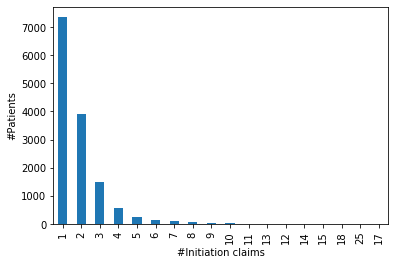

There are patients with more than 1 day=0 events
No of opioid claims taken on day0 and count of patient
1    13445
2      310
0      240
3        5
Name: sum, dtype: int64
(121547, 17)


In [9]:

# -------LTOT flag creation 

# ##Patients with >1 initiation (days=0)
rx = data_train[(data_train['event_category']=='RxClaim')]
rx.shape
rx_paid_claim = rx[(rx['event_descr']=='RX Claim - Paid') & (rx['Days']==0)]
rx_paid_claim_pat = rx_paid_claim.groupby(['id'])[['event_descr']].count().rename(columns={'event_descr':'count'})
rx_paid_claim_pat['count'].value_counts().plot(kind='bar')
xlabel('#Initiation claims')
ylabel('#Patients')
show()
print ('There are patients with more than 1 day=0 events') # ##ID10081072715 :3 claims on day 0

# ## Naive Opioid claims
rx['Naive_opioid_claim'] = np.where((rx['event_descr']=='RX Claim - Paid')& (rx['Days']==0) & (~rx['MME'].isnull()),1,0)
rx_naive_claims_pat = rx.groupby(['id'])[['Naive_opioid_claim']].sum().rename(columns={'Naive_opioid_claim':'sum'})
print ('No of opioid claims taken on day0 and count of patient')
print (rx_naive_claims_pat['sum'].value_counts())


# ##Opioid Episode level summary with LTOT flag
rx_op_claim = rx[(rx['event_descr']=='RX Claim - Paid')&(~rx['MME'].isnull())].sort_values(['id','Days'])
rx_op_claim['total_rx_MME'] = rx_op_claim['MME']*rx_op_claim['PAYABLE_QTY']
rx_op_claim['rx_cost'] = rx_op_claim['event_attr3'].map(to_float)
rx_op_claim['mem_res_cost'] = rx_op_claim['event_attr9'].map(to_float)
rx_op_claim = rx_op_claim.groupby(['id','Days'])[['rx_cost','mem_res_cost','PAY_DAY_SUPPLY_CNT','PAYABLE_QTY','total_rx_MME']].sum()
rx_op_claim.reset_index(inplace=True)
rx_op_claim['MME'] = 1*rx_op_claim['total_rx_MME']/rx_op_claim['PAY_DAY_SUPPLY_CNT']

grace = 0
# rx_op_claim = rx_op_claim[rx_op_claim['id']=='ID10010854159']
# ID10010854159
# ID10433575841
rx_op_claim['claim_end_day'] = rx_op_claim['Days']+rx_op_claim['PAY_DAY_SUPPLY_CNT']
rx_op_claim['next_op'] = rx_op_claim.groupby("id")['Days'].shift(-1) 
rx_op_claim['actual_dos'] = np.where((rx_op_claim['claim_end_day']<rx_op_claim['next_op'])|(rx_op_claim['next_op'].isnull()),rx_op_claim['PAY_DAY_SUPPLY_CNT'],rx_op_claim['next_op']-rx_op_claim['Days'])
rx_op_claim['gap_to_next_op'] = rx_op_claim['next_op']-rx_op_claim['claim_end_day']
rx_op_claim['previous_op_end_day'] = rx_op_claim.groupby("id")['claim_end_day'].shift(1) 
rx_op_claim['gap_from_previous_op'] = rx_op_claim['Days']-rx_op_claim['previous_op_end_day']
rx_op_claim['new_patient_flag'] = np.where((rx_op_claim['gap_from_previous_op'].isnull())|(rx_op_claim['gap_from_previous_op']>90),1,0)

# rx_op_claim.groupby('id')['new_patient_flag'].sum().value_counts().plot(kind='bar')

rx_op_claim['is_episode_start'] = np.where((rx_op_claim['gap_from_previous_op']>grace)|(rx_op_claim['gap_from_previous_op'].isnull()),1,0)
rx_op_claim['is_episode_end'] = np.where((rx_op_claim['next_op']>rx_op_claim['claim_end_day']+grace)|(rx_op_claim['gap_to_next_op'].isnull()),1,0)

rx_op_claim['episode_start_day'] = np.where((rx_op_claim['gap_from_previous_op']>grace)|(rx_op_claim['gap_from_previous_op'].isnull()),rx_op_claim['Days'],999999999)
rx_op_claim['episode_end_day'] = np.where((rx_op_claim['next_op']>rx_op_claim['claim_end_day']+grace)|(rx_op_claim['gap_to_next_op'].isnull()),rx_op_claim['claim_end_day'],-99999999)
rx_op_claim['episode_rank'] = rx_op_claim.groupby(['id','is_episode_start'])['episode_start_day'].rank(method='dense')


rx_op_claim.reset_index(inplace=True)
for index, row in rx_op_claim.iterrows():      
    if int(index)==0:
        rx_op_claim.loc[index,'episode_num'] = 1
    else:
        if (rx_op_claim.loc[index,'is_episode_start']==0)&(rx_op_claim.loc[index,'episode_rank']==1):
            rx_op_claim.loc[index,'episode_num'] = rx_op_claim.loc[int(index)-1,'episode_num']
        else:
            rx_op_claim.loc[index,'episode_num'] = rx_op_claim.loc[index,'episode_rank']

aggregation = {'episode_start_day':min,'episode_end_day':max,'actual_dos':sum,
               'PAY_DAY_SUPPLY_CNT':sum,'PAYABLE_QTY':sum,'total_rx_MME':sum,
               'rx_cost':sum,'mem_res_cost':sum}        
rx_op_episode = rx_op_claim.groupby(['id','episode_num']).agg(aggregation)
rx_op_episode['prescribed_MME_per_day'] = 1*rx_op_episode['total_rx_MME']/rx_op_episode['PAY_DAY_SUPPLY_CNT']
rx_op_episode['consumed_MME_per_day'] = 1*rx_op_episode['total_rx_MME']/rx_op_episode['actual_dos']
rx_op_episode['in_next_180_days'] = np.where((rx_op_episode['episode_start_day']>=0)&(rx_op_episode['episode_start_day']<180),1,0)
rx_op_episode['cutoff_180_day'] = np.where((rx_op_episode['in_next_180_days']==1)&(rx_op_episode['episode_end_day']<180),rx_op_episode['episode_end_day'],180)

rx_op_episode.reset_index(inplace=True)
for index, row in rx_op_episode.iterrows():
    if rx_op_episode.loc[index,'in_next_180_days']==1:
        if (rx_op_episode.loc[index,'episode_end_day']<180):
            rx_op_episode.loc[index,'cutoff_180_day'] = rx_op_episode.loc[index,'episode_end_day']-rx_op_episode.loc[index,'episode_start_day']
        else:
            rx_op_episode.loc[index,'cutoff_180_day'] = 180-rx_op_episode.loc[index,'episode_start_day']
    else:
        rx_op_episode.loc[index,'cutoff_180_day'] = 0
        
rx_op_episode_180 = rx_op_episode[rx_op_episode['in_next_180_days']==1]
rx_op_episode_180_1 = rx_op_episode_180.groupby(['id'])['cutoff_180_day'].sum()
rx_op_episode_180_1 = pd.DataFrame({'id':rx_op_episode_180_1.index, 'days_on_op_next_180':rx_op_episode_180_1.values})
rx_op_episode_180_1['LTOT_flag'] = np.where(rx_op_episode_180_1['days_on_op_next_180']>=162,1,0)
rx_op_episode =  rx_op_episode.merge(rx_op_episode_180_1,
                                      left_on='id',
                                      right_on='id',
                                      how='left',
                                      suffixes=['_ep', '_LTOT'])
rx_op_episode['category'] = np.where(rx_op_episode['episode_start_day']<0,'pre','post')

ltot = rx_op_episode.groupby(['id'])['LTOT_flag'].max()
ltot = pd.DataFrame({'id':ltot.index, 'LTOT_flag':ltot.values})

print (rx_op_episode.shape)





In [9]:
# ## coding parameters
# import re
warnings.filterwarnings('ignore')
col = ['id','event_descr','event_attr1','event_attr2','event_attr3','event_attr4','event_attr5','Days_d']
drop_col = ['event_attr1','event_attr2','event_attr3','event_attr4','event_attr5','event_attr6','event_attr7','event_attr8']

# ################################
# Feature extraction:
# Pre/Post-
# Total number of opioid episodes
# total length of episode:sum(episode_len)
# total length of therapy:max(episode_end)-min(episode_start)

# Gap from last Opioid before initiation : 
    
# ################################

data_dx = data_train[(data_train['event_category']=='Claim')]
data_dx['pre_flag'] = np.where(data_dx['Days']<=0,1,0)

# --------------Opioid intake related features
aggregation = {'actual_dos':sum,'PAY_DAY_SUPPLY_CNT':sum,'PAYABLE_QTY':sum,'total_rx_MME':sum,
              'rx_cost':sum,'mem_res_cost':sum}        
id_op_mat = rx_op_episode.groupby(['id','category']).agg(aggregation)
id_op_mat.reset_index(inplace=True)
id_op_mat = id_op_mat[id_op_mat['category']=='pre']
id_op_mat.drop('category',axis=1,inplace=True)
id_op_mat.set_index('id',inplace=True)
id_op_mat.shape

# ------ Latest Dx before initiation (day=0) and days since last Dx
data_dx_pre = data_dx[(data_dx['pre_flag']==1)&(data_dx['event_descr']=='Fully Paid Claim')]
# data_dx_pre = data_dx_pre[data_dx_pre['id_d']== 'ID71291582272'] 
idx = data_dx_pre.groupby(['id'])['Days'].transform(max) == data_dx_pre['Days']
latest_dx = data_dx_pre[idx]        
latest_dx1 = latest_dx.groupby(['id','event_attr1','event_attr2','Days'])[['id']].count().rename(columns={'id':'count'})
latest_dx1.reset_index(inplace=True)
latest_dx1['rank_count'] = latest_dx1.groupby(['id'])['count'].rank(method='first',ascending=False)
latest_dx_id = latest_dx1[latest_dx1['rank_count']==1]
latest_dx_id = latest_dx_id[['id','event_attr1','event_attr2','Days']].rename(columns={'event_attr1':'latest_dx_desc','event_attr2':'latest_dx_pot','Days':'Days_last_dx'})
latest_dx_id.set_index('id',inplace=True)

# ------ other Dx features
data_dx_pre['tot_charge_amt'] = data_dx_pre['event_attr3'].map(to_float)
data_dx_pre['net_paid_amt'] = data_dx_pre['event_attr4'].map(to_float)
data_dx_pre['mbr_res_amt'] = data_dx_pre['event_attr5'].map(to_float)
data_dx_pre['mbr_res_amt'] = np.where(data_dx_pre['mbr_res_amt']<0,0,data_dx_pre['mbr_res_amt'])
feature_dx1 = data_dx_pre.groupby(['id'])[['tot_charge_amt','net_paid_amt','mbr_res_amt']].sum()
feature_dx1 = feature_dx1.reset_index()
feature_dx1.set_index('id',inplace=True)

# feature_dx1.plot.scatter(x='net_paid_amt',y='mbr_res_amt',c='LTOT_flag',colormap='viridis',sharex=False)
# feature_dx1.hist(bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=1.5)
# show()
# feature_dx1.describe()

# ------ latest New Dx before initiation (day=0) and days since last new Dx
data_new_dx = data_train[(data_train['event_category']=='Diagnosis')]
data_new_dx['pre_flag'] = np.where(data_new_dx['Days']<=0,1,0)
data_new_dx_pre = data_new_dx[(data_new_dx['pre_flag']==1)]
nidx = data_new_dx_pre.groupby(['id'])['Days'].transform(max) == data_new_dx_pre['Days']
latest_new_dx = data_new_dx_pre[nidx]  
latest_new_dx['new_dx_CPD'] = np.where(latest_new_dx['event_descr']=='New diagnosis - CPD',1,0)
latest_new_dx['new_dx_hypertension'] = np.where(latest_new_dx['event_descr']=='New diagnosis - Hypertension',1,0)
latest_new_dx['new_dx_top5'] = np.where(latest_new_dx['event_descr']=='New diagnosis - Top 5',1,0)
latest_new_dx['new_dx_CAD'] = np.where(latest_new_dx['event_descr']=='New diagnosis - CAD',1,0)
latest_new_dx['new_dx_diabetes'] = np.where(latest_new_dx['event_descr']=='New diagnosis - Diabetes',1,0)
latest_new_dx['new_dx_CHF'] = np.where(latest_new_dx['event_descr']=='New diagnosis - CHF',1,0)
latest_new_dx_id = latest_new_dx.groupby(['id','Days'])['new_dx_CPD','new_dx_hypertension','new_dx_top5','new_dx_CAD','new_dx_diabetes','new_dx_CHF'].max()
latest_new_dx_id = latest_new_dx_id.reset_index().rename(columns={'Days':'latest_new_dx_day'})
latest_new_dx_id.set_index('id',inplace=True)
latest_new_dx_id.describe()
# latest_new_dx_id[:5]
# 5711 patients with new dx

# ------- calls related features
data_call = data_train[(data_train['event_category']=='Call')]
data_call['pre_flag'] = np.where(data_call['Days']<=0,1,0)
data_call_pre = data_call[data_call['pre_flag']==1]
data_call_pre_id = data_call_pre.groupby(['id','event_descr'])[['id']].count().rename(columns={'id':'number_calls'})
data_call_pre_id.reset_index(inplace=True)
data_call_pre_id['call_by_mbr'] = np.where(data_call_pre_id['event_descr']=='Inbound Call by Mbr',data_call_pre_id['number_calls'],0)
data_call_pre_id['call_by_prov'] = np.where(data_call_pre_id['event_descr']=='Inbound Call by Prov',data_call_pre_id['number_calls'],0)
data_call_pre_id['call_by_other'] = np.where(data_call_pre_id['event_descr']=='Inbound Call by Other',data_call_pre_id['number_calls'],0)
feature_data_call = data_call_pre_id.groupby(['id'])['call_by_mbr','call_by_prov','call_by_other'].max()
feature_data_call = feature_data_call.reset_index()
feature_data_call.set_index('id',inplace=True)
# feature_data_call[:5]

# ------- provider related features
data_prov = data_train[(data_train['event_category']=='Provider')]
data_prov['pre_flag'] = np.where(data_prov['Days']<=0,1,0)
data_prov_pre = data_prov[data_prov['pre_flag']==1]
pidx = data_prov_pre.groupby(['id'])['Days'].transform(max) == data_prov_pre['Days']
latest_new_prov = data_prov_pre[pidx]  
latest_new_prov = latest_new_prov[['id','Days']].rename(columns={'Days':'latest_new_prov_date'})
# latest_new_prov = latest_new_prov.reset_index()
latest_new_prov.set_index('id',inplace=True)

# ------ Latest Surgery before initiation (day=0) and days since last surgery
data_sx_pre = data_dx[(data_dx['pre_flag']==1)&(data_dx['event_descr']=='Surgery')]
# data_sx_pre = data_sx_pre[data_sx_pre['id_d']== 'ID99421949451'] 
idsx = data_sx_pre.groupby(['id'])['Days'].transform(max) == data_sx_pre['Days']
latest_sx = data_sx_pre[idsx]

latest_sx1 = latest_sx.groupby(['id','event_attr1','event_attr2','Days'])[['id']].count().rename(columns={'id':'count'})
latest_sx1.reset_index(inplace=True)
latest_sx1['rank_count'] = latest_sx1.groupby(['id'])['count'].rank(method='first',ascending=False)
latest_sx_id = latest_sx1[latest_sx1['rank_count']==1]
latest_sx_id = latest_sx_id[['id','event_attr1','event_attr2','Days']].rename(columns={'event_attr1':'latest_sx_desc','event_attr2':'latest_sx_pot','Days':'Days_last_sx'})
latest_sx_id.set_index('id',inplace=True)



# ---------------------------Rx feature code
rx_other_paid = rx[rx['event_descr'] == 'RX Claim - Paid']

rx_other_paid['tx_cat'] = rx_other_paid['event_attr6'].map(tx_cat)
rx_other_paid['tx_cat'] = np.where(~rx_other_paid['MME'].isnull(),'Opioid Treatment',rx_other_paid['tx_cat'])

#taking only negative day claims for analysis further
rx_other_paid = rx_other_paid[rx_other_paid['Days'] <0]

# Total claim count
rx_other_paid0 = pd.DataFrame(rx_other_paid.groupby('id')['id'].agg('count'))
rx_other_paid0.columns = ['claim_count']
rx_other_paid0.reset_index(inplace=True)
rx_other_paid0.set_index('id',inplace=True)

# Total claim count by category
rx_other_paid1 = pd.DataFrame(rx_other_paid.groupby(['id', 'tx_cat'])['id'].agg('count'))
rx_other_paid1.columns = ['claim_count']
rx_other_paid1.reset_index(inplace=True)
rx_other_paid2 = pd.DataFrame(pd.pivot_table(rx_other_paid1, index = 'id', columns = 'tx_cat', values = 'claim_count')).reset_index()
rx_other_paid2.fillna(0, inplace=True)
rx_other_paid2.set_index('id',inplace=True)

# Average gap between two claims of same category
rx_other_paid['claim_end_day'] = rx_other_paid['Days']+rx_other_paid['PAY_DAY_SUPPLY_CNT']
rx_other_paid3 = rx_other_paid[['id', 'tx_cat', 'Days', 'claim_end_day']]
rx_other_paid3['same_cat_next_claim_day'] = rx_other_paid3.groupby(["id","tx_cat"])['Days'].shift(-1)
rx_other_paid3['next_claim_day'] = rx_other_paid3.groupby("id")['Days'].shift(-1)
rx_other_paid3['same_cat_gap'] = rx_other_paid3['same_cat_next_claim_day']-rx_other_paid3['Days']
rx_other_paid3['gap'] = rx_other_paid3['next_claim_day']-rx_other_paid3['Days']
rx_other_paid4 = pd.DataFrame(rx_other_paid3.groupby(['id','tx_cat'])['same_cat_gap'].mean())
rx_other_paid4.columns = ['same_cat_avg_gap']
rx_other_paid4.reset_index(inplace=True)
rx_other_paid4 = pd.DataFrame(pd.pivot_table(rx_other_paid4, index = 'id', columns = 'tx_cat', values = 'same_cat_avg_gap')).reset_index()
rx_other_paid4.fillna(0, inplace=True)
rx_other_paid4.set_index('id',inplace=True)

# Average gap between two claims overall
rx_other_paid5 = pd.DataFrame(rx_other_paid3.groupby('id')['gap'].mean())
rx_other_paid5.columns = ['avg_gap']
rx_other_paid5.reset_index(inplace=True)
rx_other_paid5.set_index('id',inplace=True)

# Last claim before Day 0
rx_other_paid['gap_from_last_claim_end'] = np.where((rx_other_paid['PAY_DAY_SUPPLY_CNT'].isnull()),0-rx_other_paid['Days'],0-(rx_other_paid['Days']+rx_other_paid['PAY_DAY_SUPPLY_CNT']))
rx_other_paid6 = rx_other_paid.copy(deep=True)
rx_other_paid6['id_claim_rank'] = rx_other_paid6.groupby('id')['Days'].rank(method='first', ascending=False)
rx_other_paid6 = rx_other_paid6[rx_other_paid6['id_claim_rank'] == 1]
rx_other_paid6.set_index('id',inplace=True)

# Last Opioid claim before Day 0
mask2 = rx_other_paid['MME'].notnull()
rx_other_paid7 = rx_other_paid.loc[mask2]
rx_other_paid7['opioid_claim_rank'] = rx_other_paid7.groupby('id')['Days'].rank(method='first', ascending=False)
rx_other_paid7 = rx_other_paid7[rx_other_paid7['opioid_claim_rank'] == 1]
rx_other_paid7.set_index('id',inplace=True)

# Sum of all amounts
rx_other_paid8 = rx_other_paid.copy(deep=True)
rx_other_paid8['event_attr3'] = rx_other_paid8['event_attr3'].map(to_float)
rx_other_paid8['event_attr4'] = rx_other_paid8['event_attr4'].map(to_float)
rx_other_paid8.fillna(0, inplace=True)
rx_other_paid9 = rx_other_paid8.groupby(['id'])[['event_attr3', 'event_attr4', 'event_attr9']].sum()
rx_other_paid9.columns = ['tot_rx_cost', 'tot_net_paid_amt', 'tot_mem_res_amt']
rx_other_paid9.reset_index(inplace=True)
rx_other_paid9.set_index('id',inplace=True)


# Rejected claims
rx_rejected = rx[(rx['event_descr'] == 'RX Claim - Rejected')&(rx['Days']<0)]

# Total rejected claim count
rx_rejected1 = pd.DataFrame(rx_rejected.groupby('id')['id'].count())
rx_rejected1.columns = ['rejected_claim_count']
rx_rejected1.reset_index(inplace=True)
rx_rejected1.set_index('id',inplace=True)


# Total rejected claim count by reason
rx_rejected2 = pd.DataFrame(rx_rejected.groupby(['id', 'event_attr1'])['id'].count())
rx_rejected2.columns = ['reason_rejected_claim_count']
rx_rejected2.reset_index(inplace = True)
rx_rejected3 = pd.DataFrame(pd.pivot_table(rx_rejected2, index = 'id', columns = 'event_attr1', 
                                           values = 'reason_rejected_claim_count')).reset_index()
rx_rejected3.fillna(0, inplace=True)

# Total first mail order claim count
rx_first_mail = rx[rx['event_descr'] == 'RX Claim - First Time Mail Order']
rx_first_mail1 = pd.DataFrame(rx_first_mail.groupby('id')['id'].count())
rx_first_mail1.columns = ['first_mail_claim_count']
rx_first_mail1.reset_index(inplace=True)
rx_first_mail1.set_index('id',inplace=True)

# ------List of all unique id 
# ------use table : ltot instead 
# all_id = data_train.groupby('id')['id'].count().rename(columns={'id':'count'})
# all_id = pd.DataFrame({'id':all_id.index, 'no_records':all_id.values})
# print(len(all_id))

# rx_first_mail1[:10]
# rx_other_paid2
# rx_other_paid5[:2]
# rx_other_paid7[:10]


print ('done')


done


In [21]:
import seaborn as sns
# ------- Feature matrix creation
feature_mat0 = ltot.join(latest_dx_id, on='id', how='left')
feature_mat1 = feature_mat0.join(latest_new_dx_id, on='id',how='left')
feature_mat2 = feature_mat1.join(feature_dx1, on='id',how='left')
feature_mat3 = feature_mat2.join(latest_new_prov, on='id',how='left')
feature_mat4 = feature_mat3.join(feature_data_call, on='id',how='left')
feature_mat5 = feature_mat4.join(id_op_mat, on='id',how='left')
feature_mat6 = feature_mat5.join(latest_sx_id, on='id',how='left')
feature_mat7 = feature_mat6.join(rx_other_paid7['claim_end_day'], on='id',how='left')
feature_mat8 = feature_mat7.join(rx_other_paid2, on='id',how='left')
feature_mat9 = feature_mat8.join(rx_rejected1, on='id',how='left')
feature_mat = feature_mat9.join(rx_other_paid9, on='id',how='left')

values = {'new_dx_CPD':0,'new_dx_hypertension': 0,'new_dx_top5': 0,'new_dx_CAD': 0,'new_dx_diabetes':0,
          'new_dx_CHF':0,'latest_new_dx_day':0,'latest_sx_desc':'unk','latest_sx_pot':'unk',
          'Days_last_sx':0,'latest_new_prov_date':0,'call_by_mbr':0,'call_by_other':0,'call_by_prov':0,
         'actual_dos':0,'PAY_DAY_SUPPLY_CNT':0,'PAYABLE_QTY':0,'total_rx_MME':0,'rx_cost':0,'mem_res_cost':0,
         'claim_end_day':0,'Opioid Treatment':0,'Other Treatment':0,'Pain Treatment':0,'rejected_claim_count':0,
         'rejection_ratio':0,'latest_dx_desc':'unk','latest_dx_pot':'unk','Days_last_dx':0,
         'tot_charge_amt':0,'net_paid_amt':0,'mbr_res_amt':0,'tot_rx_cost':0,
         'tot_net_paid_amt':0,'tot_mem_res_amt':0,'op_rx_cost_share':0,'LTOT_flag':0}

feature_mat = feature_mat.fillna(value=values)
feature_mat['net_mbr_res_amt'] = feature_mat['mbr_res_amt']+feature_mat['mem_res_cost']+feature_mat['tot_mem_res_amt']
feature_mat['op_rx_cost_share'] = feature_mat['mem_res_cost']/feature_mat['tot_mem_res_amt']

feature_mat['no_new_dx_flag'] = np.where(feature_mat['latest_new_dx_day'].isnull(),1,0) 
feature_mat['no_new_sx_flag'] = np.where(feature_mat['Days_last_sx'].isnull(),1,0)
feature_mat['on_op_pre'] = np.where(~feature_mat['actual_dos'].isnull(),1,0)
feature_mat['Days_last_sx_bkt'] = pd.qcut(feature_mat['Days_last_sx'].values, 5,duplicates='drop').codes
feature_mat['latest_new_dx_day_bkt'] = pd.qcut(feature_mat['latest_new_dx_day'].values, 5,duplicates='drop').codes
feature_mat['claim_end_day_bkt'] = pd.qcut(feature_mat['claim_end_day'].values, 5,duplicates='drop').codes
feature_mat['actual_dos_bkt'] = pd.qcut(feature_mat['actual_dos'].values, 5,duplicates='drop').codes
feature_mat['rejection_ratio'] = 1*(feature_mat['rejected_claim_count'])/(feature_mat['Opioid Treatment']+feature_mat['Other Treatment']+feature_mat['Pain Treatment'])
# feature_mat['Days_last_dx_bkt'] = pd.qcut(feature_mat['Days_last_dx'].values, 5).codes




# bins = np.array([0,5,25,50,150,250,1000,5000,10000])

feature_mat_tr = feature_mat.fillna(value=values)

feature_mat_tr.rename(columns={'actual_dos':'actual_dos_op_pre','PAY_DAY_SUPPLY_CNT':'dos_op_pre',
                           'PAYABLE_QTY':'op_qty_pre','total_rx_MME':'MME','rx_cost':'tot_rx_cost_op',
                           'mem_res_cost':'mem_res_cost_op','claim_end_day':'last_op_claim_end_day',
                           'Opioid Treatment':'claims_op_pre','Other Treatment':'claims_oth_pre',
                           'Pain Treatment':'claims_pain_pre','actual_dos_bkt':'actual_dos_op_pre_bkt',
                           'tot_charge_amt':'dx_tot_charge_amt','net_paid_amt':'dx_net_paid_amt',
                           'mbr_res_amt':'dx_mbr_res_amt','claim_end_day_bkt':'last_op_claim_end_day_bkt'},inplace=True)

print("Column-wise missing value percentage")
print(feature_mat_tr.isnull().sum()/len(feature_mat_tr)*100)




# feature_mat.columns#[:10]


# feature_mat.describe()
# feature_mat['LTOT_flag'].sum()/len(feature_mat)*100


# feature_mat.plot.scatter(x='dx_mbr_res_amt',y='dx_tot_charge_amt',c='LTOT_flag',colormap='viridis',sharex=False)
# xlabel('mbr_res_amt')
# ylabel('tot_charge_amt')
# show()

# # mbr_res_amt
# sc_var = ['claims_op_pre','claims_oth_pre','claims_pain_pre']
# # sc_var = ['actual_dos_op_pre','dos_op_pre','op_qty_pre','MME','tot_rx_cost_op','mem_res_cost_op','mbr_res_amt','last_op_claim_end_day']

# corr = feature_mat[sc_var].corr()
# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=90,
#     horizontalalignment='right'
# #     ax.set_xticks(np.arange(15)
# );
# show()



IndexError: index 0 is out of bounds for axis 0 with size 0

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier as sgd
from sklearn.model_selection import cross_val_score as cvs, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, average_precision_score, precision_recall_curve, roc_curve,roc_auc_score,classification_report
from sklearn.preprocessing import StandardScaler
from inspect import signature
from pandas_ml import ConfusionMatrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [18]:
print (feature_mat_tr.shape)
print (feature_mat_ho.shape)


(13966, 46)
(6000, 46)


In [39]:
dataset = feature_mat_tr#[:100]
holdout = feature_mat_ho

x_var = ['no_new_dx_flag','Days_last_sx_bkt', 'Days_last_dx',
         'latest_new_dx_day_bkt',
         'dx_mbr_res_amt','call_by_mbr','call_by_prov','call_by_other',
         'actual_dos_op_pre_bkt','op_qty_pre','on_op_pre','MME','mem_res_cost_op','last_op_claim_end_day_bkt',
        'claims_pain_pre','claims_oth_pre','claims_op_pre','rejection_ratio']

X = dataset[x_var]
Y = dataset['LTOT_flag']
X_ho = holdout[x_var]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.40, random_state=15)

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data
# X_ho = scaler.transform(X_ho)

# print ('Train:',len(X_train),' Test:',len(X_test))
# print (X_ho.describe())


################### Baseline classifier

class base_classifier(BaseEstimator):
    def fit(self, X, Y):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

base_clf = base_classifier()
base_accuracy = cvs(base_clf, X, Y, cv=3, scoring='accuracy')


# ################### Building SGD Classifier

sgd_clf = sgd(alpha=0.0001, average=False, class_weight=None,
           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
           l1_ratio=0.3, learning_rate='optimal', loss='modified_huber', max_iter=10,
           n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
           random_state=20, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

sgd_model = sgd_clf.fit(X_train,Y_train)
sgd_accuracy = cvs(sgd_clf, X_test, Y_test, cv=3, scoring='accuracy')
y_test_pred = cvp(sgd_clf, X_test, Y_test, cv=3)
y_scores = cvp(sgd_clf, X_test, Y_test, cv=3,method='decision_function')
fpr, tpr, th = roc_curve(Y_test,y_scores)
sgd_auc = roc_auc_score(Y_test, y_test_pred)

xgb_clf = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, 
                        objective="binary:logistic", booster="gbtree", tree_method="auto",
                        n_jobs=1, gpu_id=-1, gamma=0, min_child_weight=1, max_delta_step=0,
                        subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, 
                        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0,
                        missing=None)


# -------------RandomForest

rf_clf = RandomForestClassifier(n_estimators=60, criterion="entropy", max_depth=30, 
                                min_samples_split=5, min_samples_leaf=4, min_weight_fraction_leaf=0.0,
                                max_features="auto", max_leaf_nodes=None, min_impurity_decrease=0.0,
                                min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
                                random_state=40, verbose=0, warm_start=False, class_weight=None)

# # Number of trees in random forest
# n_estimators = [10,50,200,500]
# # int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [10,20,30,50,100]
# max_depth.append(None)
# # int(x) for x in np.linspace(10, 110, num = 11)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [2, 4, 6]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

                                
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [25, 30, 35, 50],
#     'max_features': ['sqrt'],
#     'min_samples_leaf': [3, 5, 10],
#     'min_samples_split': [3, 5, 10],
#     'n_estimators': [50, 60, 80, 100]
# }
# # {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30}

# grid_search = GridSearchCV(estimator = rf_clf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)



# --------train model here
rf_model_rcv = rf_random.fit(X_train, Y_train)
rf_model = rf_clf.fit(X_train,Y_train)




# xgb_param = rf_model_rcv.get_xgb_params()
# extra = {'num_class': 3}
# xgb_param.update(extra)

# rf_accuracy_train = cvs(rf_model_rcv, X_train, Y_train, cv=3, scoring='accuracy')
# rf_accuracy = cvs(rf_model_rcv, X_test, Y_test, cv=3, scoring='accuracy')
# y_test_pred_rf = cvp(rf_model_rcv, X_test, Y_test, cv=3)
# y_train_pred_rf = cvp(rf_model_rcv, X_train, Y_train, cv=3)

# y_prob_forest = cvp(rf_model_rcv, X_test, Y_test, cv=3,method='predict_proba')

y_test_pred_rf = rf_model_rcv.predict(X_test)
y_train_pred_rf = rf_model_rcv.predict(X_train)
y_prob_forest = rf_model_rcv.predict_proba(X_test)
y_scores_forest = y_prob_forest[:,1]

y_prob_forest_ho = rf_model_rcv.predict_proba(X_ho)
y_scores_forest_ho = y_prob_forest_ho[:,1]

y_prob_forest_train = rf_model_rcv.predict_proba(X_train)
y_scores_forest_train = y_prob_forest_train[:,1]


fpr_rf_test, tpr_rf_test, th_rf_test = roc_curve(Y_test,y_scores_forest)
rf_auc_test = roc_auc_score(Y_test, y_test_pred_rf)
fpr_rf_train, tpr_rf_train, th_rf_train = roc_curve(Y_train,y_scores_forest_train)
rf_auc_train = roc_auc_score(Y_train, y_train_pred_rf)

print (rf_model_rcv.best_params_)

# ---------------RandomForest on entire data
# rf_model_all = rf_clf.fit(X,Y)
rf_accuracy_all = cvs(rf_model, X, Y, cv=3, scoring='accuracy')
y_all_pred_rf = cvp(rf_model, X, Y, cv=3)
y_prob_forest_all = cvp(rf_model, X, Y, cv=3,method='predict_proba')
y_scores_forest_all = y_prob_forest_all[:,1]
fpr_rfall, tpr_rfall, th_rfall = roc_curve(Y,y_scores_forest_all)
rf_auc_all = roc_auc_score(Y, y_all_pred_rf)

y_prob_forest_ho_rf_clf = rf_model.predict_proba(X_ho)
y_scores_forest_ho_rf_clf = y_prob_forest_ho_rf_clf[:,1]



# ------------------GradientBoost
# gbm_clf = GradientBoostingClassifier(loss="deviance", learning_rate=0.1, n_estimators=1000, 
#                                      subsample=1.0, criterion="friedman_mse", min_samples_split=2, 
#                                      min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, 
#                                      min_impurity_decrease=0.0, min_impurity_split=None, init=None,
#                                      random_state=None, max_features=None, verbose=0, max_leaf_nodes=None,
#                                      warm_start=False, presort="auto", validation_fraction=0.1,
#                                      n_iter_no_change=None, tol=0.0001)

# gbm_model = gbm_clf.fit(X_train,Y_train)
# gbm_accuracy_train = cvs(gbm_model, X_train, Y_train, cv=3, scoring='accuracy')
# gbm_accuracy_test = cvs(gbm_model, X_test, Y_test, cv=3, scoring='accuracy')
# y_test_pred_gbm = cvp(gbm_model, X_test, Y_test, cv=3)
# y_test_prob_gbm = cvp(gbm_model, X_test, Y_test, cv=3,method='predict_proba')
# y_test_scores_gbm = y_test_prob_gbm[:,1]
# fpr_gbm, tpr_gbm, th_gbm = roc_curve(Y_test,y_test_scores_gbm)
# gbm_auc = roc_auc_score(Y_test, y_test_pred_gbm)

# gbm_model = gbm_clf.fit(X,Y)
# gbm_accuracy_train = cvs(gbm_model, X, Y, cv=3, scoring='accuracy')
# gbm_accuracy_test = cvs(gbm_model, X, Y, cv=3, scoring='accuracy')
# y_test_pred_gbm = cvp(gbm_model, X, Y, cv=3)
# y_test_prob_gbm = cvp(gbm_model, X, Y, cv=3,method='predict_proba')
# y_test_scores_gbm = y_test_prob_gbm[:,1]
# fpr_gbm, tpr_gbm, th_gbm = roc_curve(Y,y_test_scores_gbm)
# gbm_auc = roc_auc_score(Y, y_test_pred_gbm)


# ---------ROC curve
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate : FP/FP+TN')
    plt.ylabel('True Positive Rate : TP/TP+FN')
    
plt.plot(fpr_rf_train,tpr_rf_train,"b:",label="XGB-train auto tuned")
plot_roc_curve(fpr_rf_test,tpr_rf_test,"XGB-test auto tuned")
plot_roc_curve(fpr_rfall,tpr_rfall,"RF-clf")
# plot_roc_curve(fpr_gbm,tpr_gbm,"GBM test")
plt.legend(loc="lower right")
plt.show()

# ----------- model evaluation
print ('rf accuracy all (TP+TN/n): ',rf_accuracy_all.mean(),'|rf accuracy Train: ',rf_accuracy_train.mean(),'|rf accuracy Test: ',rf_accuracy.mean())
print ('rf accuracy (TP+TN/n): ',rf_accuracy.mean())
print ('sgd accuracy (TP+TN/n: ',sgd_accuracy.mean())
print ('base accuracy (TP+TN/n: ',base_accuracy.mean())

cm = confusion_matrix(Y_test, y_test_pred)
cm_rf = confusion_matrix(Y_test, y_test_pred_rf)
cm_rf_all = confusion_matrix(Y, y_all_pred_rf)
index = ['NON LTOT','LTOT']  
columns = ['NON LTOT','LTOT']    
cm_df = pd.DataFrame(cm,columns,index)
cm_df_rf = pd.DataFrame(cm_rf,columns,index)
# print ('SGD')
# plt.figure(figsize=(5,3))  
# sns.heatmap(cm_df,annot=True,fmt='g')
# show()
# print ('RF')
# plt.figure(figsize=(5,3))  
# sns.heatmap(cm_rf,annot=True,fmt='g')
# show()
print ('RF all')
plt.figure(figsize=(5,3))  
sns.heatmap(cm_rf_all,annot=True,fmt='g')
show()
print(classification_report(Y, y_all_pred_rf)) ##, target_names=target_names

# cm_gbm = confusion_matrix(Y, y_test_pred_gbm)
# print('GBM')
# plt.figure(figsize=(5,3))  
# sns.heatmap(cm_gbm,annot=True,fmt='g')
# show()

# print ('gbm accuracy Train: ',gbm_accuracy_train.mean(),'|gbm accuracy Test: ',gbm_accuracy_test.mean())
# print(classification_report(Y, y_test_pred_gbm)) ##, target_names=target_names
# print ('gbm_auc=',gbm_auc)
print('train auc auto tuned=',rf_auc_train)
print('test auc auto tuned=',rf_auc_test)
print('rf_auc rf_clf=',rf_auc_all)

feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = x_var,
                                    columns=['importance']).sort_values('importance',ascending=False)
print (feature_importances)

# ---------summary final model on entire data 
# df = X_ho
# df['y_pred_rf'] = y_scores_forest
# df['y_pred_gbm'] = y_test_pred_gbm

def create_label(row,col):
    if row['LTOT_flag'] == row[col] and row[col]==1:
        return 'TP'
    elif row['LTOT_flag'] == row[col] and row[col]==0:
        return 'TN'
    elif row['LTOT_flag'] != row[col] and row[col]==0:
        return 'FN'
    else:
        return 'FP'

# df['label_rf'] = df.apply (lambda row: create_label(row,'y_pred_rf'), axis=1)
# df['label_gbm'] = df.apply (lambda row: create_label(row,'y_pred_gbm'), axis=1)


# summary_var = ['label','dos_op_pre','MME']
# claims_oth_pre           0.101260
# rejected_claim_count     0.091630
# MME                      0.090429
# call_by_mbr              0.080635
# mem_res_cost_op          0.066694
# last_op_claim_end_day    0.060812
# claims_op_pre            0.058836
# Days_last_sx_bkt         0.037470
# latest_new_dx_day_bkt    0.025136
# no_new_sx_flag           0.008547
# on_op_pre                0.007803
# new_dx_CPD               0.007772
# new_dx_hypertension      0.007461
# no_new_dx_flag           0.007335
# new_dx_diabetes          0.006155
# new_dx_CAD               0.005924
# new_dx_CHF               0.005332
# df[summary_var].groupby('label').describe()

# df.iloc[1]



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


XGBoostError: value -1 for Parameter gpu_id should be greater equal to 0

In [38]:
df=feature_mat_ho
df['LTOT_prob_rf'] = y_scores_forest_ho_rf_clf
df['rank'] = df['LTOT_prob_rf'].rank(method='dense',ascending=False)
df['rank'].describe()
df.to_csv('holdoutset_result.csv',index=False)

(13966, 46)

In [89]:

# ---------New patient df creation
data = data_train
# data = data[data['id']=='ID10010854159']
data['Days_str'] = data['Days'].map(to_str)
data['key'] = data['id']+data['Days_str']
data = data.sort_values(['id','Days','event_category'])

# rx_op_claim[rx_op_claim['new_patient_flag']==1]['Days'].hist()
op_new_pat = rx_op_claim[rx_op_claim['new_patient_flag']==1][['id','Days','new_patient_flag']]
op_new_pat['initiation_rank'] = op_new_pat.groupby(['id'])['Days'].rank(method='dense')
# op_new_pat[op_new_pat['initiation_rank']==1]['Days'].hist()
# show()
op_new_pat['Days_str'] = op_new_pat['Days'].map(to_str)
op_new_pat['key'] = op_new_pat['id']+op_new_pat['Days_str']

data_p1 = data.merge(op_new_pat,
               left_on='key',
               right_on='key',
               how='left',
               suffixes=['_d', '_I'])
ltot = rx_op_episode.groupby(['id'])['LTOT_flag'].max()
ltot = pd.DataFrame({'id':ltot.index, 'LTOT_flag':ltot.values})
# len(ltot[ltot['LTOT_flag'].isnull()])
# 149
ltot['LTOT_flag'] = ltot['LTOT_flag'].fillna(0)
ltot.set_index('id')

data_p2 = data_p1.merge(ltot,
               left_on='id_d',
               right_on='id',
               how='left')
print(data_p2.shape())

all_id = pd.DataFrame(data_p2.groupby('id_d')['LTOT_flag'].max())
all_id[:10]


TypeError: 'tuple' object is not callable

In [ ]:
# -------All id with LTOT flag
data_train['id'] = data_train['id'].map(to_str)
rx_op_episode['id'] = rx_op_episode['id'].map(to_str)

ltot = rx_op_episode.groupby(['id'])['LTOT_flag'].max()
ltot = pd.DataFrame({'id':ltot.index, 'LTOT_flag':ltot.values})
# 13966 patients
all_id = data_train.groupby('id')['id'].count().rename(columns={'id':'count'})
all_id = pd.DataFrame({'id':all_id.index, 'no_records':all_id.values})

print(all_id.dtypes)
print(ltot.dtypes)

print(len(all_id))
print(len(ltot))

# all_id = all_id.join(ltot, on='id', how='left')
# all_id.fillna(value={'LTOT_flag':0})
# print(all_id['LTOT_flag'].value_counts())

# pd.merge(df1.assign(x=df1.x.astype(str)), 
#          df2.assign(x=df2.x.astype(str)), 
#          how='left', on='x')


In [ ]:
dx = data_train[(data_train['event_category'] == 'Diagnosis') | (data_train['event_category'] == 'Claim')]
dx.shape

# ##comment below line
# dx = dx[:10000]

def to_float(s):
    return float(s)

dx['charge_amt'] = dx['event_attr3'].map(to_float)
dx['net_amt_paid'] = dx['event_attr4'].map(to_float)
dx['member_res_amt'] = dx['event_attr5'].map(to_float)
dx_pat_att = dx.groupby(['id'])[['charge_amt','net_amt_paid','member_res_amt']].sum()
pat_len = data_train.groupby('id').apply(lambda x: x.Days.max() - x.Days.min())
pat_len = pd.DataFrame({'id':pat_len.index, 'len':pat_len.values})
dx_pat = dx_pat_att.join(pat_len.set_index('id'), on='id')

dx_pat['norm_charge_amt'] = dx_pat['charge_amt']/dx_pat['len']
dx_pat['norm_net_amt_paid'] = dx_pat['net_amt_paid']/dx_pat['len']
dx_pat['norm_member_res_amt'] = dx_pat['member_res_amt']/dx_pat['len']

# plot(dx_pat['len'], dx_pat['norm_member_res_amt'], marker='o', color='blue', linestyle='None')
# xlabel('len')
# ylabel('norm_member_res_amt')
#show()
# ## ID10166893764

# ##Types of diagnosis
dx_pat_diag = dx.groupby(['id','event_descr'])[['event_descr']].count().rename(columns={'event_descr':'count'})
dx_pat_diag.reset_index(inplace=True)
dx_pat_diag_pv = dx_pat_diag.pivot_table(index='id', columns='event_descr', values='count', fill_value=0)
dx_pat_diag_pv.shape

# dx_pat = dx_pat.join(dx_pat_diag_pv, on='id')
# dx_pat['norm_dx_claim_count'] = dx_pat['Fully Paid Claim']/dx_pat['len']

# plot(dx_pat['Surgery'], dx_pat['norm_dx_claim_count'], marker='o', color='blue', linestyle='None')
# xlabel('Surgery')
# ylabel('norm_dx_claim_count')
# show()

# print (dx_pat['Surgery'].min())
# print (dx_pat['Surgery'].max())

# dx_pat['Surgery'].value_counts().plot(kind='bar')


# Identifying LTOT patients

# Creating pre/post flag

In [ ]:
pd.options.display.max_rows = 400

def to_str(s):
    return str(s)


# ## New patient df creation
data = data_train
# data = data[data['id']=='ID10010854159']
data['Days_str'] = data['Days'].map(to_str)
data['key'] = data['id']+data['Days_str']
data = data.sort_values(['id','Days','event_category'])

# rx_op_claim[rx_op_claim['new_patient_flag']==1]['Days'].hist()
op_new_pat = rx_op_claim[rx_op_claim['new_patient_flag']==1][['id','Days','new_patient_flag']]
op_new_pat['initiation_rank'] = op_new_pat.groupby(['id'])['Days'].rank(method='dense')
# op_new_pat[op_new_pat['initiation_rank']==1]['Days'].hist()
# show()
op_new_pat['Days_str'] = op_new_pat['Days'].map(to_str)
op_new_pat['key'] = op_new_pat['id']+op_new_pat['Days_str']

data_p1 = data.merge(op_new_pat,
               left_on='key',
               right_on='key',
               how='left',
               suffixes=['_d', '_I'])
ltot = rx_op_episode.groupby(['id'])['LTOT_flag'].max()
ltot = pd.DataFrame({'id':ltot.index, 'LTOT_flag':ltot.values})
# len(ltot[ltot['LTOT_flag'].isnull()])
# 149
ltot['LTOT_flag'] = ltot['LTOT_flag'].fillna(0)
ltot.set_index('id')

data_p2 = data_p1.merge(ltot,
               left_on='id_d',
               right_on='id',
               how='left')
data_p2[:5]

In [ ]:
# data_p2[data_p2['LTOT_flag'].isnull()]#['id']#.drop_duplicates()#.count()

ltot1 = rx_op_episode.groupby(['id'])['LTOT_flag'].max()
ltot1 = pd.DataFrame({'id':ltot1.index, 'LTOT_flag':ltot1.values})
# len(ltot[ltot['LTOT_flag'].isnull()])
# 149



# ID10433575841
# ID1624200167
# rx_op_episode[rx_op_episode['id']=='ID10433575841']

# opioid=['OPIOID COMBINATIONS','OPIOID AGONISTS','OPIOID PARTIAL AGONISTS','ANTIPERISTALTIC AGENTS']

# len(data_p1[(data_p1['event_descr']=='RX Claim - Paid')&(data_p1['event_attr1'].isin(opioid))]['id_d'].drop_duplicates())

# # data_p1[(data_p1['event_descr']=='RX Claim - Paid')&(~data_p1['MME'].isnull())]['event_attr1'].value_counts()

# #['event_attr1'].value_counts()

# ltot1[ltot1['LTOT_flag'].isnull()]
# data_p1[(data_p1['id_d']=='ID1624200167')][['MME','PAY_DAY_SUPPLY_CNT','event_descr','event_attr1','Days_d']]#.min()
# data_p2
# # print("Column-wise missing value percentage")
# print(data_p2.isnull().sum()/len(data_p2)*100)

# data_p2['LTOT_flag'] = np.where(data_p2['LTOT_flag'].isnull(),0,data_p2['LTOT_flag'])

# print("Column-wise missing value percentage")
# print(data_p2.isnull().sum()/len(data_p2)*100)
feature_mat.shape

# d = data_p2.groupby('id')['LTOT_flag'].max()
all_id = pd.DataFrame(data_p2.groupby('id')['LTOT_flag'].max())
all_id[:10]
# all_id.index


In [ ]:
# ## coding parameters
# import re
warnings.filterwarnings('ignore')
col = ['id','event_descr','event_attr1','event_attr2','event_attr3','event_attr4','event_attr5','Days_d']
drop_col = ['event_attr1','event_attr2','event_attr3','event_attr4','event_attr5','event_attr6','event_attr7','event_attr8']

# ################################
# Feature extraction:
# Pre/Post-
# Total number of opioid episodes
# total length of episode:sum(episode_len)
# total length of therapy:max(episode_end)-min(episode_start)

# Gap from last Opioid before initiation : 
    
# ################################

data_dx = data_p2[(data_p2['event_category']=='Claim')&(~data_p2['LTOT_flag'].isnull())]
data_dx['pre_flag'] = np.where(data_dx['Days_d']<=0,1,0)


# ------- Opioid intake related features
aggregation = {'actual_dos':sum,'PAY_DAY_SUPPLY_CNT':sum,'PAYABLE_QTY':sum,'total_rx_MME':sum,
              'rx_cost':sum,'mem_res_cost':sum}        
id_op_mat = rx_op_episode.groupby(['id','category']).agg(aggregation)
id_op_mat.reset_index(inplace=True)
id_op_mat = id_op_mat[id_op_mat['category']=='pre']
id_op_mat.drop('category',axis=1,inplace=True)
id_op_mat.set_index('id',inplace=True)
id_op_mat.shape

# ------ Latest Dx before initiation (day=0) and days since last Dx
data_dx_pre = data_dx[(data_dx['pre_flag']==1)&(data_dx['event_descr']=='Fully Paid Claim')]
# data_dx_pre = data_dx_pre[data_dx_pre['id_d']== 'ID71291582272'] 
idx = data_dx_pre.groupby(['id'])['Days_d'].transform(max) == data_dx_pre['Days_d']
latest_dx = data_dx_pre[idx]        
latest_dx1 = latest_dx.groupby(['id_d','event_attr1','event_attr2','Days_d','LTOT_flag'])[['id_d']].count().rename(columns={'id_d':'count'})
latest_dx1.reset_index(inplace=True)
latest_dx1['rank_count'] = latest_dx1.groupby(['id_d'])['count'].rank(method='first',ascending=False)
latest_dx_id = latest_dx1[latest_dx1['rank_count']==1]
latest_dx_id = latest_dx_id[['id_d','event_attr1','event_attr2','Days_d']].rename(columns={'event_attr1':'latest_dx_desc','event_attr2':'latest_dx_pot','id_d':'id','Days_d':'Days_last_dx'})
latest_dx_id.set_index('id',inplace=True)

# ------ other Dx features
data_dx_pre['tot_charge_amt'] = data_dx_pre['event_attr3'].map(to_float)
data_dx_pre['net_paid_amt'] = data_dx_pre['event_attr4'].map(to_float)
data_dx_pre['mbr_res_amt'] = data_dx_pre['event_attr5'].map(to_float)
data_dx_pre['mbr_res_amt'] = np.where(data_dx_pre['mbr_res_amt']<0,0,data_dx_pre['mbr_res_amt'])
feature_dx1 = data_dx_pre.groupby(['id_d'])[['tot_charge_amt','net_paid_amt','mbr_res_amt']].sum()
feature_dx1 = feature_dx1.reset_index().rename(columns={'id_d':'id'})
feature_dx1.set_index('id',inplace=True)

# feature_dx1.plot.scatter(x='net_paid_amt',y='mbr_res_amt',c='LTOT_flag',colormap='viridis',sharex=False)
# feature_dx1.hist(bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=1.5)
# show()
feature_dx1.describe()

# ------ latest New Dx before initiation (day=0) and days since last new Dx
data_new_dx = data_p2[(data_p2['event_category']=='Diagnosis')&(~data_p2['LTOT_flag'].isnull())]
data_new_dx['pre_flag'] = np.where(data_new_dx['Days_d']<=0,1,0)
data_new_dx_pre = data_new_dx[(data_new_dx['pre_flag']==1)]
nidx = data_new_dx_pre.groupby(['id'])['Days_d'].transform(max) == data_new_dx_pre['Days_d']
latest_new_dx = data_new_dx_pre[nidx]  
latest_new_dx['new_dx_CPD'] = np.where(latest_new_dx['event_descr']=='New diagnosis - CPD',1,0)
latest_new_dx['new_dx_hypertension'] = np.where(latest_new_dx['event_descr']=='New diagnosis - Hypertension',1,0)
latest_new_dx['new_dx_top5'] = np.where(latest_new_dx['event_descr']=='New diagnosis - Top 5',1,0)
latest_new_dx['new_dx_CAD'] = np.where(latest_new_dx['event_descr']=='New diagnosis - CAD',1,0)
latest_new_dx['new_dx_diabetes'] = np.where(latest_new_dx['event_descr']=='New diagnosis - Diabetes',1,0)
latest_new_dx['new_dx_CHF'] = np.where(latest_new_dx['event_descr']=='New diagnosis - CHF',1,0)
latest_new_dx_id = latest_new_dx.groupby(['id','Days_d'])['new_dx_CPD','new_dx_hypertension','new_dx_top5','new_dx_CAD','new_dx_diabetes','new_dx_CHF'].max()
latest_new_dx_id = latest_new_dx_id.reset_index().rename(columns={'id_d':'id','Days_d':'latest_new_dx_day'})
latest_new_dx_id.set_index('id',inplace=True)
latest_new_dx_id.describe()
# latest_new_dx_id[:5]
# 5711 patients with new dx

# ------- calls related features
data_call = data_p2[(data_p2['event_category']=='Call')&(~data_p2['LTOT_flag'].isnull())]
data_call['pre_flag'] = np.where(data_call['Days_d']<=0,1,0)
data_call_pre = data_call[data_call['pre_flag']==1]
data_call_pre_id = data_call_pre.groupby(['id','LTOT_flag','event_descr'])[['id']].count().rename(columns={'id':'number_calls'})
data_call_pre_id.reset_index(inplace=True)
data_call_pre_id['call_by_mbr'] = np.where(data_call_pre_id['event_descr']=='Inbound Call by Mbr',data_call_pre_id['number_calls'],0)
data_call_pre_id['call_by_prov'] = np.where(data_call_pre_id['event_descr']=='Inbound Call by Prov',data_call_pre_id['number_calls'],0)
data_call_pre_id['call_by_other'] = np.where(data_call_pre_id['event_descr']=='Inbound Call by Other',data_call_pre_id['number_calls'],0)
feature_data_call = data_call_pre_id.groupby(['id'])['call_by_mbr','call_by_prov','call_by_other'].max()
feature_data_call = feature_data_call.reset_index()
feature_data_call.set_index('id',inplace=True)
# feature_data_call[:5]

# ------- provider related features
data_prov = data_p2[(data_p2['event_category']=='Provider')&(~data_p2['LTOT_flag'].isnull())]
data_prov['pre_flag'] = np.where(data_prov['Days_d']<=0,1,0)
data_prov_pre = data_prov[data_prov['pre_flag']==1]
pidx = data_prov_pre.groupby(['id'])['Days_d'].transform(max) == data_prov_pre['Days_d']
latest_new_prov = data_prov_pre[pidx]  
latest_new_prov = latest_new_prov[['id','Days_d']].rename(columns={'Days_d':'latest_new_prov_date'})
# latest_new_prov = latest_new_prov.reset_index()
latest_new_prov.set_index('id',inplace=True)

# ------ Latest Surgery before initiation (day=0) and days since last surgery
data_sx_pre = data_dx[(data_dx['pre_flag']==1)&(data_dx['event_descr']=='Surgery')]
# data_sx_pre = data_sx_pre[data_sx_pre['id_d']== 'ID99421949451'] 
idsx = data_sx_pre.groupby(['id'])['Days_d'].transform(max) == data_sx_pre['Days_d']
latest_sx = data_sx_pre[idsx]

latest_sx1 = latest_sx.groupby(['id_d','event_attr1','event_attr2','Days_d','LTOT_flag'])[['id_d']].count().rename(columns={'id_d':'count'})
latest_sx1.reset_index(inplace=True)
latest_sx1['rank_count'] = latest_sx1.groupby(['id_d'])['count'].rank(method='first',ascending=False)
latest_sx_id = latest_sx1[latest_sx1['rank_count']==1]
latest_sx_id = latest_sx_id[['id_d','event_attr1','event_attr2','Days_d']].rename(columns={'event_attr1':'latest_sx_desc','event_attr2':'latest_sx_pot','id_d':'id','Days_d':'Days_last_sx'})
latest_sx_id.set_index('id',inplace=True)

print ('done')
# # --------------------
# print ('LTOT Patient')
# latest_sx_id[latest_sx_id['LTOT_flag']==1]['Days_last_sx'].hist()
# xlabel('Days since last surgery')
# ylabel('# Patients')
# show()
# latest_dx_id[latest_dx_id['LTOT_flag']==1]['Days_last_dx'].hist()
# xlabel('Days since last dx')
# ylabel('# Patients')
# show()

# print ('Non LTOT Patient')
# latest_sx_id[latest_sx_id['LTOT_flag']==0]['Days_last_sx'].hist()
# xlabel('Days since last surgery')
# ylabel('# Patients')
# show()
# latest_dx_id[latest_dx_id['LTOT_flag']==0]['Days_last_dx'].hist()
# xlabel('Days since last dx')
# ylabel('# Patients')
# show()







# len(data_sx_pre)
# print (len(latest_sx1['id_d'].drop_duplicates()))
# latest_sx_id[:10]#[col]

# --------------------
# data_dx['event_descr'].value_counts()
# Fully Paid Claim    1731058
# Surgery               30937

# input_str = 'ALLERGIC RHINITIS, CAUSE UNSPECIFIED'
# def check_pain(input_str):
#     if any(re.findall(r'pain|hypertension|ALLERGIC', input_str, re.IGNORECASE)):
#         return 1
#     else:
#         return 0
# check_pain(input_str)





In [ ]:
def tx_cat(s):
    if s in('PAIN','OTH-STEROIDS','PSYCH-ANX','PSYCH-DEP','NUISANCE-SLEEP','PSYCH','NUISANCE-STIMULANTS',
            'CARDIO', 'CANCER', 'OTH-THYROID','OTH-GROWTH HORMONE'):
        return 'Pain Treatment'
    else:
        return 'Other Treatment'

In [ ]:
rx_other_paid = rx[rx['event_descr'] == 'RX Claim - Paid']

rx_other_paid['tx_cat'] = rx_other_paid['event_attr6'].map(tx_cat)
rx_other_paid['tx_cat'] = np.where(~rx_other_paid['MME'].isnull(),'Opioid Treatment',rx_other_paid['tx_cat'])

# np.where(rx_other_paid['MME'].notnull(), 'Opioid Treatment', rx_other_paid['event_attr6'].map(tx_cat))

# rx_other_paid = pd.DataFrame(rx_other_paid[['id', 'event_attr1', 'event_attr3',
#                                              'event_attr4', 'event_attr5', 'event_attr6','event_attr8',
#                                              'event_attr9', 'event_attr10', 'Days','PAY_DAY_SUPPLY_CNT', 'PAYABLE_QTY', 
#                                              'MME', 'Specialty','Specialty2', 'Specialty3', 'event_category', 'tx_cat']])

#taking only negative day claims for analysis further
rx_other_paid = rx_other_paid[rx_other_paid['Days'] <0]

# Total claim count
rx_other_paid0 = pd.DataFrame(rx_other_paid.groupby('id')['id'].agg('count'))
rx_other_paid0.columns = ['claim_count']
rx_other_paid0.reset_index(inplace=True)
rx_other_paid0.set_index('id',inplace=True)

# Total claim count by category
rx_other_paid1 = pd.DataFrame(rx_other_paid.groupby(['id', 'tx_cat'])['id'].agg('count'))
rx_other_paid1.columns = ['claim_count']
rx_other_paid1.reset_index(inplace=True)
rx_other_paid2 = pd.DataFrame(pd.pivot_table(rx_other_paid1, index = 'id', columns = 'tx_cat', values = 'claim_count')).reset_index()
rx_other_paid2.fillna(0, inplace=True)
rx_other_paid2.set_index('id',inplace=True)

# Average gap between two claims of same category
rx_other_paid['claim_end_day'] = rx_other_paid['Days']+rx_other_paid['PAY_DAY_SUPPLY_CNT']
rx_other_paid3 = rx_other_paid[['id', 'tx_cat', 'Days', 'claim_end_day']]
rx_other_paid3['same_cat_next_claim_day'] = rx_other_paid3.groupby(["id","tx_cat"])['Days'].shift(-1)
rx_other_paid3['next_claim_day'] = rx_other_paid3.groupby("id")['Days'].shift(-1)
rx_other_paid3['same_cat_gap'] = rx_other_paid3['same_cat_next_claim_day']-rx_other_paid3['Days']
rx_other_paid3['gap'] = rx_other_paid3['next_claim_day']-rx_other_paid3['Days']
rx_other_paid4 = pd.DataFrame(rx_other_paid3.groupby(['id','tx_cat'])['same_cat_gap'].mean())
rx_other_paid4.columns = ['same_cat_avg_gap']
rx_other_paid4.reset_index(inplace=True)
rx_other_paid4 = pd.DataFrame(pd.pivot_table(rx_other_paid4, index = 'id', columns = 'tx_cat', values = 'same_cat_avg_gap')).reset_index()
rx_other_paid4.fillna(0, inplace=True)
rx_other_paid4.set_index('id',inplace=True)

# Average gap between two claims overall
rx_other_paid5 = pd.DataFrame(rx_other_paid3.groupby('id')['gap'].mean())
rx_other_paid5.columns = ['avg_gap']
rx_other_paid5.reset_index(inplace=True)
rx_other_paid5.set_index('id',inplace=True)

# Last claim before Day 0
rx_other_paid['gap_from_last_claim_end'] = np.where((rx_other_paid['PAY_DAY_SUPPLY_CNT'].isnull()),0-rx_other_paid['Days'],0-(rx_other_paid['Days']+rx_other_paid['PAY_DAY_SUPPLY_CNT']))
rx_other_paid6 = rx_other_paid.copy(deep=True)
rx_other_paid6['id_claim_rank'] = rx_other_paid6.groupby('id')['Days'].rank(method='first', ascending=False)
rx_other_paid6 = rx_other_paid6[rx_other_paid6['id_claim_rank'] == 1]
rx_other_paid6.set_index('id',inplace=True)

# Last Opioid claim before Day 0
mask2 = rx_other_paid['MME'].notnull()
rx_other_paid7 = rx_other_paid.loc[mask2]
rx_other_paid7['opioid_claim_rank'] = rx_other_paid7.groupby('id')['Days'].rank(method='first', ascending=False)
rx_other_paid7 = rx_other_paid7[rx_other_paid7['opioid_claim_rank'] == 1]
rx_other_paid7.set_index('id',inplace=True)

# Sum of all amounts
rx_other_paid8 = rx_other_paid.copy(deep=True)
rx_other_paid8['event_attr3'] = rx_other_paid8['event_attr3'].map(to_float)
rx_other_paid8['event_attr4'] = rx_other_paid8['event_attr4'].map(to_float)
rx_other_paid8.fillna(0, inplace=True)
rx_other_paid9 = rx_other_paid8.groupby(['id'])[['event_attr3', 'event_attr4', 'event_attr9']].sum()
rx_other_paid9.columns = ['tot_rx_cost', 'tot_net_paid_amt', 'tot_mem_res_amt']
rx_other_paid9.reset_index(inplace=True)
rx_other_paid9.set_index('id',inplace=True)


# Rejected claims
rx_rejected = rx[(rx['event_descr'] == 'RX Claim - Rejected')&(rx['Days']<0)]

# Total rejected claim count
rx_rejected1 = pd.DataFrame(rx_rejected.groupby('id')['id'].count())
rx_rejected1.columns = ['rejected_claim_count']
rx_rejected1.reset_index(inplace=True)
rx_rejected1.set_index('id',inplace=True)


# Total rejected claim count by reason
rx_rejected2 = pd.DataFrame(rx_rejected.groupby(['id', 'event_attr1'])['id'].count())
rx_rejected2.columns = ['reason_rejected_claim_count']
rx_rejected2.reset_index(inplace = True)
rx_rejected3 = pd.DataFrame(pd.pivot_table(rx_rejected2, index = 'id', columns = 'event_attr1', 
                                           values = 'reason_rejected_claim_count')).reset_index()
rx_rejected3.fillna(0, inplace=True)

# Total first mail order claim count
rx_first_mail = rx[rx['event_descr'] == 'RX Claim - First Time Mail Order']
rx_first_mail1 = pd.DataFrame(rx_first_mail.groupby('id')['id'].count())
rx_first_mail1.columns = ['first_mail_claim_count']
rx_first_mail1.reset_index(inplace=True)
rx_first_mail1.set_index('id',inplace=True)


# rx_first_mail1[:10]
# rx_other_paid2
rx_other_paid5[:2]
# rx_other_paid7[:10]



In [ ]:
len(rx_other_paid9[rx_other_paid9.isnull()])
rx_other_paid9[rx_other_paid9.isnull()]
# ID10010854159
# rx_other_paid9[rx_other_paid9['id']=='ID10010854159']
# rx_other_paid9.columns
# rx_other_paid9['tot_rx_cost'].isnull()#[:5]

In [ ]:
import seaborn as sns
# ------- Feature matrix creation
feature_mat0 = all_id.join(latest_dx_id, on='id', how='left')
feature_mat1 = feature_mat0.join(latest_new_dx_id, on='id',how='left')
feature_mat2 = feature_mat1.join(feature_dx1, on='id',how='left')
feature_mat3 = feature_mat2.join(latest_new_prov, on='id',how='left')
feature_mat4 = feature_mat3.join(feature_data_call, on='id',how='left')
feature_mat5 = feature_mat4.join(id_op_mat, on='id',how='left')
feature_mat6 = feature_mat5.join(latest_sx_id, on='id',how='left')
feature_mat7 = feature_mat6.join(rx_other_paid7['claim_end_day'], on='id',how='left')
feature_mat8 = feature_mat7.join(rx_other_paid2, on='id',how='left')
feature_mat9 = feature_mat8.join(rx_rejected1, on='id',how='left')
feature_mat = feature_mat9.join(rx_other_paid9, on='id',how='left')

feature_mat['no_new_dx_flag'] = np.where(feature_mat['latest_new_dx_day'].isnull(),1,0) 
feature_mat['no_new_sx_flag'] = np.where(feature_mat['Days_last_sx'].isnull(),1,0)
feature_mat['on_op_pre'] = np.where(~feature_mat['actual_dos'].isnull(),1,0)
feature_mat['Days_last_sx_bkt'] = pd.qcut(feature_mat['Days_last_sx'].values, 5).codes
feature_mat['latest_new_dx_day_bkt'] = pd.qcut(feature_mat['latest_new_dx_day'].values, 5).codes
feature_mat['claim_end_day_bkt'] = pd.qcut(feature_mat['claim_end_day'].values, 5).codes
feature_mat['actual_dos_bkt'] = pd.qcut(feature_mat['actual_dos'].values, 5).codes
feature_mat['rejection_ratio'] = 1*(feature_mat['rejected_claim_count'])/(feature_mat['Opioid Treatment']+feature_mat['Other Treatment']+feature_mat['Pain Treatment'])
# feature_mat['Days_last_dx_bkt'] = pd.qcut(feature_mat['Days_last_dx'].values, 5).codes
feature_mat['net_mbr_res_amt'] = feature_mat['mbr_res_amt']+feature_mat['mem_res_cost']+feature_mat['tot_mem_res_amt']
feature_mat['op_rx_cost_share'] = feature_mat['mem_res_cost']/feature_mat['tot_mem_res_amt']




# bins = np.array([0,5,25,50,150,250,1000,5000,10000])
values = {'new_dx_CPD':0,'new_dx_hypertension': 0,'new_dx_top5': 0,'new_dx_CAD': 0,'new_dx_diabetes':0,
          'new_dx_CHF':0,'latest_new_dx_day':0,'latest_sx_desc':'unk','latest_sx_pot':'unk',
          'Days_last_sx':0,'latest_new_prov_date':0,'call_by_mbr':0,'call_by_other':0,'call_by_prov':0,
         'actual_dos':0,'PAY_DAY_SUPPLY_CNT':0,'PAYABLE_QTY':0,'total_rx_MME':0,'rx_cost':0,'mem_res_cost':0,
         'claim_end_day':0,'Opioid Treatment':0,'Other Treatment':0,'Pain Treatment':0,'rejected_claim_count':0,
         'rejection_ratio':0,'latest_dx_desc':'unk','latest_dx_pot':'unk','Days_last_dx':0,
         'tot_charge_amt':0,'net_paid_amt':0,'mbr_res_amt':0}

feature_mat = feature_mat.fillna(value=values)
feature_mat.rename(columns={'actual_dos':'actual_dos_op_pre','PAY_DAY_SUPPLY_CNT':'dos_op_pre',
                           'PAYABLE_QTY':'op_qty_pre','total_rx_MME':'MME','rx_cost':'tot_rx_cost_op',
                           'mem_res_cost':'mem_res_cost_op','claim_end_day':'last_op_claim_end_day',
                           'Opioid Treatment':'claims_op_pre','Other Treatment':'claims_oth_pre',
                           'Pain Treatment':'claims_pain_pre','actual_dos_bkt':'actual_dos_op_pre_bkt',
                           'tot_charge_amt':'dx_tot_charge_amt','net_paid_amt':'dx_net_paid_amt',
                           'mbr_res_amt':'dx_mbr_res_amt','claim_end_day_bkt':'last_op_claim_end_day_bkt'},inplace=True)

print("Column-wise missing value percentage")
print(feature_mat.isnull().sum()/len(feature_mat)*100)
# feature_mat.describe()
# feature_mat['LTOT_flag'].sum()/len(feature_mat)*100


feature_mat.plot.scatter(x='dx_mbr_res_amt',y='dx_tot_charge_amt',c='LTOT_flag',colormap='viridis',sharex=False)
xlabel('mbr_res_amt')
ylabel('tot_charge_amt')
show()

# mbr_res_amt
sc_var = ['claims_op_pre','claims_oth_pre','claims_pain_pre']
# sc_var = ['actual_dos_op_pre','dos_op_pre','op_qty_pre','MME','tot_rx_cost_op','mem_res_cost_op','mbr_res_amt','last_op_claim_end_day']

corr = feature_mat[sc_var].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
#     ax.set_xticks(np.arange(15)
);
show()

# ft = feature_mat[feature_mat['no_new_sx_flag']==0]['Days_last_sx'].hist()
# show()

# feature_mat[['last_op_claim_end_day','last_op_claim_end_day_bkt']].groupby('last_op_claim_end_day_bkt').describe()
# # feature_mat.iloc[1]

# df = ft
# # plt.subplots(2, 2, figsize=(8,6))
# def sephist(col):
#     LTOT = df[df['LTOT_flag'] == 1][col]
#     non_LTOT = df[df['LTOT_flag'] == 0][col]
#     return LTOT, non_LTOT

# for num, Days_last_sx in enumerate(ft[['Days_last_sx','LTOT_flag']]):
#     plt.subplot(2, 2, num)
#     plt.hist(sephist('Days_last_sx')[0], bins=25, alpha=0.5, label='LTOT', color='b')
#     plt.hist(sephist('Days_last_sx')[1], bins=25, alpha=0.5, label='non_LTOT', color='r')
#     plt.legend(loc='upper right')
#     plt.title(alpha)
# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# sephist('Days_last_sx')[0]
# plt.subplot(2, 2)
# bins=np.linspace(ft['Days_last_sx'].min(), ft['Days_last_sx'].max(), 10)
# g = sns.FacetGrid(ft['Days_last_sx'], col="LTOT_flag", hue="LTOT_flag", palette="Set1", col_wrap=2)
# g.map(plt.hist, ft['Days_last_sx'], bins=bins, ec="k")

# g.axes[-1].legend()
# plt.show()

# print ('done')

# feature_mat['Days_last_sx_bkt']


In [ ]:
feature_mat.shape

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier as sgd
from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, average_precision_score, precision_recall_curve, roc_curve,roc_auc_score,classification_report
from sklearn.preprocessing import StandardScaler
from inspect import signature
from pandas_ml import ConfusionMatrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
# threshold = np.linspace(-12570,25775,1000)
# threshold
# alphas =  10**np.linspace(10,-2,100)*0.5
# alphas

In [ ]:
dataset = feature_mat#[:1000]

x_var = ['no_new_dx_flag','no_new_sx_flag',
         'latest_new_dx_day_bkt','new_dx_CPD','new_dx_hypertension','new_dx_CAD','new_dx_diabetes','new_dx_CHF',
         'dx_mbr_res_amt', 'call_by_mbr',
         'Days_last_sx_bkt', 'Days_last_dx_bkt',
         'actual_dos_op_pre_bkt','on_op_pre','MME','mem_res_cost_op','last_op_claim_end_day_bkt',
        'claims_pain_pre','claims_oth_pre','claims_op_pre',
        'rejection_ratio']
# new_dx_top5
X = dataset[x_var]
Y = dataset['LTOT_flag']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.40, random_state=15)

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data
# print ('Train:',len(X_train),' Test:',len(X_test))
Y_test.describe()


################### Baseline classifier

class base_classifier(BaseEstimator):
    def fit(self, X, Y):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

base_clf = base_classifier()
base_accuracy = cvs(base_clf, X, Y, cv=3, scoring='accuracy')


# ################### Building SGD Classifier

sgd_clf = sgd(alpha=0.0001, average=False, class_weight=None,
           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
           l1_ratio=0.3, learning_rate='optimal', loss='modified_huber', max_iter=10,
           n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
           random_state=20, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

sgd_model = sgd_clf.fit(X_train,Y_train)
sgd_accuracy = cvs(sgd_clf, X_test, Y_test, cv=3, scoring='accuracy')
y_test_pred = cvp(sgd_clf, X_test, Y_test, cv=3)
y_scores = cvp(sgd_clf, X_test, Y_test, cv=3,method='decision_function')
fpr, tpr, th = roc_curve(Y_test,y_scores)
sgd_auc = roc_auc_score(Y_test, y_test_pred)


# -------------RandomForest

rf_clf = RandomForestClassifier(n_estimators=1000, criterion="entropy", max_depth=None, 
                                min_samples_split=3, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                max_features="auto", max_leaf_nodes=None, min_impurity_decrease=0.0,
                                min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
                                random_state=40, verbose=0, warm_start=False, class_weight=None)

rf_model = rf_clf.fit(X_train,Y_train)
rf_accuracy_train = cvs(rf_model, X_train, Y_train, cv=3, scoring='accuracy')
rf_accuracy = cvs(rf_model, X_test, Y_test, cv=3, scoring='accuracy')
y_test_pred_rf = cvp(rf_model, X_test, Y_test, cv=3)
y_prob_forest = cvp(rf_model, X_test, Y_test, cv=3,method='predict_proba')
y_scores_forest = y_prob_forest[:,1]
fpr_rf, tpr_rf, th_rf = roc_curve(Y_test,y_scores_forest)
rf_auc = roc_auc_score(Y_test, y_test_pred_rf)

# ---------------RandomForest on entire data
rf_model_all = rf_clf.fit(X,Y)
rf_accuracy_all = cvs(rf_model_all, X, Y, cv=3, scoring='accuracy')
y_all_pred_rf = cvp(rf_model_all, X, Y, cv=3)
y_prob_forest_all = cvp(rf_model_all, X, Y, cv=3,method='predict_proba')
y_scores_forest_all = y_prob_forest_all[:,1]
fpr_rfall, tpr_rfall, th_rfall = roc_curve(Y,y_scores_forest_all)
rf_auc_all = roc_auc_score(Y, y_all_pred_rf)

# ------------------GradientBoost
gbm_clf = GradientBoostingClassifier(loss="deviance", learning_rate=0.1, n_estimators=1000, 
                                     subsample=1.0, criterion="friedman_mse", min_samples_split=2, 
                                     min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, 
                                     min_impurity_decrease=0.0, min_impurity_split=None, init=None,
                                     random_state=None, max_features=None, verbose=0, max_leaf_nodes=None,
                                     warm_start=False, presort="auto", validation_fraction=0.1,
                                     n_iter_no_change=None, tol=0.0001)

# gbm_model = gbm_clf.fit(X_train,Y_train)
# gbm_accuracy_train = cvs(gbm_model, X_train, Y_train, cv=3, scoring='accuracy')
# gbm_accuracy_test = cvs(gbm_model, X_test, Y_test, cv=3, scoring='accuracy')
# y_test_pred_gbm = cvp(gbm_model, X_test, Y_test, cv=3)
# y_test_prob_gbm = cvp(gbm_model, X_test, Y_test, cv=3,method='predict_proba')
# y_test_scores_gbm = y_test_prob_gbm[:,1]
# fpr_gbm, tpr_gbm, th_gbm = roc_curve(Y_test,y_test_scores_gbm)
# gbm_auc = roc_auc_score(Y_test, y_test_pred_gbm)

gbm_model = gbm_clf.fit(X,Y)
gbm_accuracy_train = cvs(gbm_model, X, Y, cv=3, scoring='accuracy')
gbm_accuracy_test = cvs(gbm_model, X, Y, cv=3, scoring='accuracy')
y_test_pred_gbm = cvp(gbm_model, X, Y, cv=3)
y_test_prob_gbm = cvp(gbm_model, X, Y, cv=3,method='predict_proba')
y_test_scores_gbm = y_test_prob_gbm[:,1]
fpr_gbm, tpr_gbm, th_gbm = roc_curve(Y,y_test_scores_gbm)
gbm_auc = roc_auc_score(Y, y_test_pred_gbm)


# ---------ROC curve
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate : FP/FP+TN')
    plt.ylabel('True Positive Rate : TP/TP+FN')
    
plt.plot(fpr,tpr,"b:",label="SGD")
# plot_roc_curve(fpr_rf,tpr_rf,"RF")
plot_roc_curve(fpr_rfall,tpr_rfall,"RF-all")
plot_roc_curve(fpr_gbm,tpr_gbm,"GBM test")
plt.legend(loc="lower right")
plt.show()

# ----------- model evaluation
print ('rf accuracy all (TP+TN/n): ',rf_accuracy_all.mean(),'|rf accuracy Train: ',rf_accuracy_train.mean(),'|rf accuracy Test: ',rf_accuracy.mean())
# print ('rf accuracy (TP+TN/n): ',rf_accuracy.mean())
print ('sgd accuracy (TP+TN/n: ',sgd_accuracy.mean())
print ('base accuracy (TP+TN/n: ',base_accuracy.mean())

cm = confusion_matrix(Y_test, y_test_pred)
cm_rf = confusion_matrix(Y_test, y_test_pred_rf)
cm_rf_all = confusion_matrix(Y, y_all_pred_rf)
index = ['NON LTOT','LTOT']  
columns = ['NON LTOT','LTOT']    
cm_df = pd.DataFrame(cm,columns,index)
cm_df_rf = pd.DataFrame(cm_rf,columns,index)
# print ('SGD')
# plt.figure(figsize=(5,3))  
# sns.heatmap(cm_df,annot=True,fmt='g')
# show()
# print ('RF')
# plt.figure(figsize=(5,3))  
# sns.heatmap(cm_rf,annot=True,fmt='g')
# show()
print ('RF all')
plt.figure(figsize=(5,3))  
sns.heatmap(cm_rf_all,annot=True,fmt='g')
show()
print(classification_report(Y, y_all_pred_rf)) ##, target_names=target_names

cm_gbm = confusion_matrix(Y, y_test_pred_gbm)
print('GBM')
plt.figure(figsize=(5,3))  
sns.heatmap(cm_gbm,annot=True,fmt='g')
show()

print ('gbm accuracy Train: ',gbm_accuracy_train.mean(),'|gbm accuracy Test: ',gbm_accuracy_test.mean())
print(classification_report(Y, y_test_pred_gbm)) ##, target_names=target_names
print ('gbm_auc=',gbm_auc)
print('sgd_auc=',sgd_auc)
# print('rf_auc=',rf_auc)
print('rf_auc_all=',rf_auc_all)

feature_importances = pd.DataFrame(rf_model_all.feature_importances_,
                                   index = x_var,
                                    columns=['importance']).sort_values('importance',ascending=False)
print (feature_importances)

# ---------summary final model on entire data 
df = dataset
df['y_pred_rf'] = y_all_pred_rf
df['y_pred_gbm'] = y_test_pred_gbm

def create_label(row,col):
    if row['LTOT_flag'] == row[col] and row[col]==1:
        return 'TP'
    elif row['LTOT_flag'] == row[col] and row[col]==0:
        return 'TN'
    elif row['LTOT_flag'] != row[col] and row[col]==0:
        return 'FN'
    else:
        return 'FP'

df['label_rf'] = df.apply (lambda row: create_label(row,'y_pred_rf'), axis=1)
df['label_gbm'] = df.apply (lambda row: create_label(row,'y_pred_gbm'), axis=1)


# summary_var = ['label','dos_op_pre','MME']
# claims_oth_pre           0.101260
# rejected_claim_count     0.091630
# MME                      0.090429
# call_by_mbr              0.080635
# mem_res_cost_op          0.066694
# last_op_claim_end_day    0.060812
# claims_op_pre            0.058836
# Days_last_sx_bkt         0.037470
# latest_new_dx_day_bkt    0.025136
# no_new_sx_flag           0.008547
# on_op_pre                0.007803
# new_dx_CPD               0.007772
# new_dx_hypertension      0.007461
# no_new_dx_flag           0.007335
# new_dx_diabetes          0.006155
# new_dx_CAD               0.005924
# new_dx_CHF               0.005332
# df[summary_var].groupby('label').describe()

# df.iloc[1]



In [ ]:

# df1 = scaler.transform(df[['dos_op_pre','MME']])
# df1['label_rf'] = df['label_rf']

#set font size of labels on matplotlib plots
plt.rc('font', size=12)
# plt.figure(figsize=(5,3)) 

#set style of plots
sns.set_style('white')

#define a custom palette
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)

#plot data with seaborn
# plt.figure(figsize=(5,3)) 
facet = sns.lmplot(data=df, x='rejection_ratio', y='dos_op_pre', hue='label_rf', 
                   fit_reg=False, legend=True, legend_out=True)



# df.plot.scatter(x='dos_op_pre',y='mbr_res_amt',c='label_rf',label='label_rf', colormap='viridis',sharex=False)
# xlabel('dos_op_pre')
# ylabel('mbr_res_amt')
# show()


In [ ]:
# ------------------GradientBoost
gbm_clf = GradientBoostingClassifier(loss="deviance", learning_rate=0.1, n_estimators=1000, 
                                     subsample=1.0, criterion="friedman_mse", min_samples_split=2, 
                                     min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, 
                                     min_impurity_decrease=0.0, min_impurity_split=None, init=None,
                                     random_state=None, max_features=None, verbose=0, max_leaf_nodes=None,
                                     warm_start=False, presort="auto", validation_fraction=0.1,
                                     n_iter_no_change=None, tol=0.0001)

gbm_model = gbm_clf.fit(X_train,Y_train)
gbm_accuracy_train = cvs(gbm_model, X_train, Y_train, cv=3, scoring='accuracy')
gbm_accuracy_test = cvs(gbm_model, X_test, Y_test, cv=3, scoring='accuracy')
y_test_pred_gbm = cvp(gbm_model, X_test, Y_test, cv=3)
y_test_prob_gbm = cvp(gbm_model, X_test, Y_test, cv=3,method='predict_proba')
y_test_scores_gbm = y_test_prob_gbm[:,1]
fpr_gbm, tpr_gbm, th_gbm = roc_curve(Y_test,y_test_scores_gbm)
gbm_auc = roc_auc_score(Y_test, y_test_pred_gbm)

# ----------model summary
cm_gbm = confusion_matrix(Y_test, y_test_pred_gbm)
plt.figure(figsize=(5,3))  
sns.heatmap(cm_gbm,annot=True,fmt='g')
show()

plt.plot(fpr_gbm,tpr_gbm,"b:",label="GBM")
plt.legend(loc="lower right")
plt.show()

print ('rf accuracy Train: ',gbm_accuracy_train.mean(),'|rf accuracy Test: ',gbm_accuracy_test.mean())
print(classification_report(Y_test, y_test_pred_gbm)) ##, target_names=target_names
print ('gbm_auc=',gbm_auc)






# Opioid Addiction:
As part of the national effort to combat opioid overuse, Humana set a goal to reduce the number of members receiving opioid prescriptions greater than 100 morphine milligram equivalent (MME), a dosage that raises the risks of opioid overdose, by 40 percent. In 2018, Humana closed in on its goal, reducing the number of members receiving prescriptions greater than 100 MME by 36 percent.

# Diagnosis data with LTOT flag

In [ ]:
pat_LTOT = rx_op_episode.groupby('id')['LTOT_flag'].max()#.rename(columns={'id':'LTOT_flag'})
print (dx.shape)
dx_p1 = dx.merge(pat_LTOT,
               left_on='id',
               right_on='id',
               how='left',
               suffixes=['_dx', '_LTOT'])
aggregation = {'Days':min,'Days':max}        
dx_p3 = dx_p1[dx_p1['event_descr']=='Fully Paid Claim'].groupby(['id','LTOT_flag','event_attr1'])['Days'].count()
dx_p3.reset_index(inplace=True)



# dx_p1[dx_p1['id']=='ID10013863216']
# # pat_LTOT
# dx_p2 = dx_p1[dx_p1['event_descr']=='Fully Paid Claim'].groupby(['id','LTOT_flag','event_attr1'])['Days'].count()
# dx_p2.reset_index(inplace=True)
# # dx_p2 = pd.DataFrame({'id':dx_p2.index, 'count':dx_p2.values})
# dx_p2

# # dx_p2['diagnosis_rank_by_count'] = dx_p2['Days']


In [ ]:

rx_paid_claim_pat[rx_paid_claim_pat['count']>1][:5]
rx_paid_claim_nn = rx_paid_claim.loc[pd.notnull(rx_paid_claim.MME)]
rx_paid_claim_pat_1 = rx_paid_claim_nn.groupby(['id'])[['event_descr']].count().rename(columns={'event_descr':'count'})
#rx_paid_claim_pat_1['count'].value_counts().plot(kind='bar')

print ('Drug class for qualifying events (Naive opioid patients')
print (rx_paid_claim_nn['event_attr1'].value_counts())

# rx_paid_claim_nn[:5]

# print (rx_op_episode.shape)    
        
        
        
        
        
        
        
        
# aggregation = {'episode_start_day':{'episode_start_day':min},'episode_end_day':{'episode_end_day':max},'actual_dos':{'episode_len':sum}}        
#     rx_op_claim.loc[index,'episode_num'] = rx_op_claim.loc[index,'episode_rank']
#     if n>1: 
#         if (rx_op_claim.loc[n,'id']==rx_op_claim.loc[n-1,'id'])&(rx_op_claim.loc[n,'episode_rank']==1):
#             if(rx_op_claim.loc[n,'is_episode_start']==0):
#                 rx_op_claim.loc[n,'episode_num'] = rx_op_claim.loc[n-1,'episode_rank']
#             else:
#                 rx_op_claim.loc[n,'episode_num'] = rx_op_claim.loc[n,'episode_rank']
#         else:
#             rx_op_claim.loc[n,'episode_num'] = rx_op_claim.loc[n,'episode_rank']
#     else:
#         rx_op_claim.loc[n,'episode_num'] = 1


# rx_op_claim['episode_num'] = rx_op_claim.apply(lambda x:episode_num(x),axis=1)     








# rx_op_claim_1 = rx_op_claim[rx_op_claim['is_episode_start']==1]
# rx_op_claim_1['episode_number'] = rx_op_claim_1['episode_start_day'].rank(method='dense')


# grace = 0
# rx_op_claim['continuing'] = np.where(rx_op_claim[''])
# rx_naive_op_claim['days_on_op'] = np.where(rx_naive_op_claim['gap_to_next_op']<rx_naive_op_claim['PAY_DAY_SUPPLY_CNT'],rx_naive_op_claim['gap_to_next_op'],rx_naive_op_claim['PAY_DAY_SUPPLY_CNT'])
# rx_naive_op_claim['in_next_180_days'] = np.where((rx_naive_op_claim['Days']>=0)&(rx_naive_op_claim['Days']<180),1,0)
# rx_LTOT_1 = rx_naive_op_claim[(rx_naive_op_claim['Days']>=0)&(rx_naive_op_claim['Days']<180)]
# rx_LTOT_2 = rx_LTOT_1.groupby(['id'])[['days_on_op']].sum()
# rx_LTOT_2.reset_index(inplace=True)
# rx_LTOT_pat = rx_LTOT_2[rx_LTOT_2['days_on_op']>=162]
# rx_LTOT_pat#['id'].value_counts()
# # rx_naive_claims_pat[rx_naive_claims_pat['sum']>2]
# [rx_op_claim['is_episode_start']==1]

# rx_op_claim_1 = rx_op_claim_1[rx_op_claim_1['id']=='ID37774657894']
rx_op_claim#.drop(drop_col,axis=1)

# rx_op_episode.reset_index(inplace=True)
# print (rx_op_episode)

rx_op_episode
# rx_op_claim
# rx_op_episode_180_1.sort_values(by='days_on_op_next_180',ascending=False)
rx_op_episode_180_1#['days_on_op_next_180'].hist()
rx_op_episode
# rx_op_claim[['id','Days','PAY_DAY_SUPPLY_CNT','actual_dos','claim_end_day','next_op']]
# rx_naive_op_claim[rx_naive_op_claim['Days']<0].max()
# rx_test = rx_naive_op_claim[rx_naive_op_claim['id']=='ID99994197161']



# rx_LTOT_1[rx_LTOT_1['id']=='ID37774657894'][col]
# # rx_LTOT_1[rx_LTOT_1['id']=='ID37774657894'][col]




# rx[~rx['MME'].isnull()].iloc[1]
# print ('event_attr6=Drug group description')
# print (rx[rx['MME'].isnull()]['event_attr6'].value_counts())
# # ## 
# print ('event_attr8=Generic name')
# rx[rx['MME'].isnull()]['event_attr8'].value_counts()#/rx[rx['MME'].isnull()]['event_attr8'].value_counts().sum()*100


# rx[~rx['MME'].isnull()]['MME'].hist(bins=[0,100,200,300,400,500,600])#.value_counts()[10]#.plot(kind='bar')
# rx[~rx['MME'].isnull()]['MME'].max()
# rx[rx['MME']==1872]
# show()

# rx_LTOT_2[rx_LTOT_2['id']=='ID10024447278']

# rx_LTOT_2

#.loc[1]
# 





# df = df[df['PRICE'] == df.groupby('ORIGIN')['PRICE'].transform('min')]


# rx_naive_op_claim.iloc[1]





# rx_test['previous_op'] = rx_test['Days'].shift(1) 

# rx_test["claim_no"] = rx_test.groupby("id")["Days"].rank("dense", ascending=True)
# rx_test = rx_test[rx_test['PRICE'] != df.groupby('ORIGIN')['PRICE'].transform('min')]


# rx_test_rnk = rx_test.groupby(['id'])[['claim_no']].sum().rename(columns={'Naive_opioid_claim':'sum'})


# rx_test


# rx_test = rx_test.loc[rx_test['claim_no'].first()]
# # rx_test.set_index([['id','Days']])

# rx_naive_op_claim[rx_naive_op_claim['id']=='ID37774657894'][]
# rx[rx['id']=='ID10180352120'].loc[(rx['event_descr']=='RX Claim - Paid')&(rx['Days']==0)&(~rx['MME'].isnull())]
# rx[rx['id']=='ID10180352120'].loc[(rx['event_descr']=='RX Claim - Paid')&(rx['Days']>0)]


In [ ]:
# fig, (ax1, ax2) = subplots(nrows=1,ncols=2)

print ('Pre initiation')
pre_dx = data_train[(data_train['Days']<0) & (data_train['event_category']=='Diagnosis')]['event_descr'].value_counts()
pre_dx.plot(kind='bar')
show()

print ('Post initiation')
post_dx = data_train[(data_train['Days']>0) & (data_train['event_category']=='Diagnosis')]['event_descr'].value_counts()
post_dx.plot(kind='bar')
show()

print ('What is New diagnosis - Top 5')


# ############################
# Day zero analysis

init = data_train[data_train['Days']==0].drop_duplicates()
init['id'].value_counts()[:10].plot(kind='bar')
show()
print ('patients present with multiple initiation event date')

data_train[(data_train['id']=='ID66796083593')&(data_train['Days']==0)&(data_train['event_descr']=='RX Claim - Paid')].sort_values(by='Days')

print('For day 0 events we see top two categories of claims as per event attr1 to be related to opioids')
data_train[(data_train['Days']==0)&(data_train['event_descr']=='RX Claim - Paid')]['event_attr1'].value_counts()[:10].plot(kind='bar')
show()

data_rx_train = data_train[data_train['event_category']=='RxClaim']
data_rx_train['event_descr'].value_counts().plot(kind='bar')
show()



# Feature
